In [1]:
import math
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from botorch.models.gpytorch import GPyTorchModel
from gpytorch.models import ExactGP
from gpytorch.distributions import MultivariateNormal
from gpytorch.means import ConstantMean
from gpytorch.kernels import RBFKernel, ScaleKernel, SpectralMixtureKernel, LinearKernel, PeriodicKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import GammaPrior
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader,TensorDataset

from botorch import fit_gpytorch_model
from botorch.exceptions import BadInitialCandidatesWarning

In [2]:
#  Define the model

class ExactGPModel(ExactGP,GPyTorchModel):
    
    _num_outputs = 1
    
    def __init__(self,train_x,train_y):
        super().__init__(train_x,train_y.squeeze(-1),GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel(train_x.shape[-1]))
        self.to(train_x)
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        
        return MultivariateNormal(mean_x,0.5*(covar_x+covar_x.transpose(0,1)))

In [3]:
#  Initialize the model
def Initialize_model(train_x,train_y,state_dict=None):
    model = ExactGPModel(train_x,train_y)
    mll = ExactMarginalLogLikelihood(model.likelihood,model)
    if state_dict is not None:
        model.load_state_dict(state_dict)
    return model,mll

In [4]:
def next_query_point(model,rem_x):
    model.eval()
    model.likelihood.eval()
    
    var = model.likelihood(model(rem_x)).variance
    ind = torch.argmax(var)
    
    return ind
    

In [5]:
import warnings 

warnings.filterwarnings('ignore',category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore',category=RuntimeWarning)

def fit(x,y,verbose=True):
    np.random.seed(42)
    # Training data for working model--> need replace with out original data
    l = int(torch.floor(torch.tensor(0.8*114)).item())
    scaler = StandardScaler()
    train_x = x[:l]
    print(train_x.shape)
    print(type(train_x))
    train_y = y[:l]
    print(train_y.shape)
    print(type(train_y))

    train_x = torch.Tensor(scaler.fit_transform(train_x))

    test_x = torch.Tensor(scaler.transform(x[l:]))
    test_y = y[l:]

    train_dataset = TensorDataset(train_x[5:],train_y[5:])

    train_loader = DataLoader(train_dataset,batch_size=10,shuffle=True)

    # Initialize the model
    train_x_al = train_x[:5]
    train_y_al = train_y[:5]
    model_al,mll_al = Initialize_model(train_x_al,train_y_al)
    model_al.state_dict()
    model_al.train()

    for b,(rem_x,rem_y) in enumerate(train_loader):
    
        if verbose:
            print(f"Batch {b+1:>3}")
        N_trails = len(rem_x)

    
        for i in range(N_trails):
        
            ind = next_query_point(model_al,rem_x)
            new_x = rem_x[ind]
            new_y = rem_y[ind]
        
    
            rem_x = torch.cat((rem_x[:ind],rem_x[ind+1:]))
            rem_y = torch.cat((rem_y[:ind],rem_y[ind+1:]))
        
        
            # update the training points 
            train_x_al = torch.cat((train_x_al,new_x.reshape(1,1)))
            train_y_al = torch.cat((train_y_al,new_y.reshape(1,1)))
        
            # reinitiate the model
            model_al,mll_al = Initialize_model(train_x_al,train_y_al,model_al.state_dict())
        
            fit_gpytorch_model(mll_al)
        
            
            optimizer = torch.optim.Adam(model_al.parameters(),lr=0.01)
        
            epochs = 10
        
            model_al.train()
        
            for epoch in range(epochs):
            
            
                # predicting on forward pass
                output = model_al(train_x_al)
            
                # compute negative marginal log likelihood
            
                loss = -mll_al(output,model_al.train_targets)
            
                optimizer.zero_grad()
            
                loss.backward()
            
                if (epoch + 1)%10 == 0 and verbose:
                    print(
                        f"Epoch {epoch+1:>3}/{epochs} - Loss:{loss.item():>4.3f},lengthscale:{model_al.covar_module.base_kernel.lengthscale.item()}")
            
                optimizer.step()
    model_al.eval()
    model_al.likelihood.eval()
    
    predictions = model_al.likelihood(model_al(test_x))
#     print(test_y.detach().numpy().shape)
    
    return test_y.detach().numpy().reshape(-1), predictions.mean.detach().numpy().reshape(-1), scaler.inverse_transform(test_x.detach().numpy().reshape(1,-1))
        

## Forecasting

In [6]:
op = [25,40,50,75]
dy = [10,20,30,40,50,60,70,80,91] # for forward year

In [7]:
result = {'actual':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []},'predictions':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], '91 years': []}}

total_x = torch.linspace(1901,2014,114).reshape(-1,1).double()
data = pd.read_csv('Optimal_averaging_using_ensemble_entire_set.dat',sep='\s+',header=None)

for i in range(9):
    total_y = torch.tensor(data.iloc[i].values.reshape(-1,1)).double()
    actual,predicted,_ = fit(total_x,total_y)
    result['actual'][str(dy[i])+' years'] = actual
    result['predictions'][str(dy[i])+' years'] = predicted

torch.Size([91, 1])
<class 'torch.Tensor'>
torch.Size([91, 1])
<class 'torch.Tensor'>
Batch   1
Epoch  10/10 - Loss:0.675,lengthscale:16.435461044311523
Epoch  10/10 - Loss:0.863,lengthscale:16.435251235961914
Epoch  10/10 - Loss:0.903,lengthscale:16.43524169921875
Epoch  10/10 - Loss:0.972,lengthscale:16.43517303466797
Epoch  10/10 - Loss:0.940,lengthscale:16.43513298034668
Epoch  10/10 - Loss:0.939,lengthscale:16.434946060180664
Epoch  10/10 - Loss:1.016,lengthscale:16.434911727905273
Epoch  10/10 - Loss:1.042,lengthscale:16.43484115600586
Epoch  10/10 - Loss:1.005,lengthscale:16.434751510620117
Epoch  10/10 - Loss:1.003,lengthscale:16.434667587280273
Batch   2
Epoch  10/10 - Loss:0.974,lengthscale:16.43456268310547
Epoch  10/10 - Loss:0.967,lengthscale:16.434467315673828
Epoch  10/10 - Loss:0.948,lengthscale:16.434423446655273
Epoch  10/10 - Loss:0.951,lengthscale:16.434419631958008
Epoch  10/10 - Loss:0.936,lengthscale:16.434406280517578
Epoch  10/10 - Loss:0.967,lengthscale:16.434

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:1.001,lengthscale:16.43426513671875
Epoch  10/10 - Loss:0.991,lengthscale:16.434246063232422
Epoch  10/10 - Loss:0.979,lengthscale:16.434226989746094
Epoch  10/10 - Loss:0.968,lengthscale:16.434207916259766
Epoch  10/10 - Loss:0.971,lengthscale:16.434179306030273
Epoch  10/10 - Loss:1.018,lengthscale:16.434141159057617
Epoch  10/10 - Loss:1.007,lengthscale:16.43410301208496


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:1.044,lengthscale:16.434040069580078
Batch   5
Epoch  10/10 - Loss:1.044,lengthscale:16.433982849121094
Epoch  10/10 - Loss:1.034,lengthscale:16.43392562866211
Epoch  10/10 - Loss:1.023,lengthscale:16.433868408203125
Epoch  10/10 - Loss:1.022,lengthscale:16.433828353881836
Epoch  10/10 - Loss:1.022,lengthscale:16.43379020690918
Epoch  10/10 - Loss:1.031,lengthscale:16.43376922607422
Epoch  10/10 - Loss:1.027,lengthscale:16.43375015258789
Epoch  10/10 - Loss:1.019,lengthscale:16.433731079101562
Epoch  10/10 - Loss:1.019,lengthscale:16.433712005615234
Epoch  10/10 - Loss:1.034,lengthscale:16.433692932128906
Batch   6
Epoch  10/10 - Loss:1.029,lengthscale:16.433673858642578
Epoch  10/10 - Loss:1.047,lengthscale:16.43365478515625
Epoch  10/10 - Loss:1.041,lengthscale:16.433635711669922
Epoch  10/10 - Loss:1.050,lengthscale:16.433616638183594
Epoch  10/10 - Loss:1.052,lengthscale:16.433597564697266
Epoch  10/10 - Loss:1.049,lengthscale:16.433578491210938
Epoch  10/10 - L

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.975,lengthscale:14.743424415588379


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.971,lengthscale:14.743376731872559
Epoch  10/10 - Loss:0.967,lengthscale:14.743329048156738
Epoch  10/10 - Loss:0.965,lengthscale:14.743289947509766
Epoch  10/10 - Loss:0.959,lengthscale:14.74325180053711
Epoch  10/10 - Loss:0.959,lengthscale:14.7432222366333
Epoch  10/10 - Loss:0.953,lengthscale:14.743193626403809
Batch   8
Epoch  10/10 - Loss:0.953,lengthscale:14.743162155151367
Epoch  10/10 - Loss:0.947,lengthscale:14.743131637573242
Epoch  10/10 - Loss:0.943,lengthscale:14.743094444274902
Epoch  10/10 - Loss:0.937,lengthscale:14.743057250976562
Epoch  10/10 - Loss:0.935,lengthscale:14.743027687072754
Epoch  10/10 - Loss:0.945,lengthscale:14.742990493774414
Epoch  10/10 - Loss:0.941,lengthscale:14.742952346801758
Epoch  10/10 - Loss:0.939,lengthscale:14.742914199829102
Epoch  10/10 - Loss:0.938,lengthscale:14.742867469787598
Epoch  10/10 - Loss:0.946,lengthscale:14.742828369140625
Batch   9
Epoch  10/10 - Loss:0.941,lengthscale:14.742790222167969
Epoch  10/10 -

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.957,lengthscale:15.22077465057373
Batch   4
Epoch  10/10 - Loss:0.944,lengthscale:15.219474792480469
Epoch  10/10 - Loss:0.941,lengthscale:15.218400955200195
Epoch  10/10 - Loss:1.006,lengthscale:15.217870712280273
Epoch  10/10 - Loss:0.994,lengthscale:15.217428207397461
Epoch  10/10 - Loss:0.986,lengthscale:15.217015266418457
Epoch  10/10 - Loss:0.985,lengthscale:15.216642379760742
Epoch  10/10 - Loss:0.975,lengthscale:15.216328620910645
Epoch  10/10 - Loss:0.965,lengthscale:15.21602725982666
Epoch  10/10 - Loss:0.970,lengthscale:15.215797424316406
Epoch  10/10 - Loss:0.959,lengthscale:15.21558666229248
Batch   5
Epoch  10/10 - Loss:0.954,lengthscale:15.215401649475098
Epoch  10/10 - Loss:0.944,lengthscale:15.21523380279541
Epoch  10/10 - Loss:0.940,lengthscale:15.215065956115723
Epoch  10/10 - Loss:0.933,lengthscale:15.214912414550781
Epoch  10/10 - Loss:0.937,lengthscale:15.214773178100586
Epoch  10/10 - Loss:0.934,lengthscale:15.214629173278809
Epoch  10/10 - 

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.975,lengthscale:15.212360382080078
Epoch  10/10 - Loss:0.972,lengthscale:15.212329864501953
torch.Size([91, 1])
<class 'torch.Tensor'>
torch.Size([91, 1])
<class 'torch.Tensor'>
Batch   1
Epoch  10/10 - Loss:0.504,lengthscale:12.188021659851074
Epoch  10/10 - Loss:0.735,lengthscale:12.18578052520752
Epoch  10/10 - Loss:0.837,lengthscale:12.182729721069336
Epoch  10/10 - Loss:0.795,lengthscale:12.178816795349121
Epoch  10/10 - Loss:0.869,lengthscale:12.17746353149414
Epoch  10/10 - Loss:0.981,lengthscale:12.176183700561523
Epoch  10/10 - Loss:0.986,lengthscale:12.174871444702148
Epoch  10/10 - Loss:0.950,lengthscale:12.173595428466797
Epoch  10/10 - Loss:0.929,lengthscale:12.172128677368164
Epoch  10/10 - Loss:0.917,lengthscale:12.170845031738281
Batch   2
Epoch  10/10 - Loss:0.920,lengthscale:12.16956901550293
Epoch  10/10 - Loss:0.890,lengthscale:12.168269157409668
Epoch  10/10 - Loss:0.886,lengthscale:12.166580200195312
Epoch  10/10 - Loss:0.909,lengthscale:12.1

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.877,lengthscale:12.150055885314941
Epoch  10/10 - Loss:0.878,lengthscale:12.14953899383545
Epoch  10/10 - Loss:0.867,lengthscale:12.149081230163574
Epoch  10/10 - Loss:0.878,lengthscale:12.14869499206543
Epoch  10/10 - Loss:0.866,lengthscale:12.148320198059082
Epoch  10/10 - Loss:0.855,lengthscale:12.147936820983887
Epoch  10/10 - Loss:0.870,lengthscale:12.147668838500977
Epoch  10/10 - Loss:0.918,lengthscale:12.147327423095703
Epoch  10/10 - Loss:0.910,lengthscale:12.146992683410645
Batch   5


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.903,lengthscale:12.14670181274414
Epoch  10/10 - Loss:0.901,lengthscale:12.1464262008667
Epoch  10/10 - Loss:0.893,lengthscale:12.146146774291992
Epoch  10/10 - Loss:0.892,lengthscale:12.1458740234375
Epoch  10/10 - Loss:0.933,lengthscale:12.145581245422363
Epoch  10/10 - Loss:0.931,lengthscale:12.145263671875
Epoch  10/10 - Loss:0.923,lengthscale:12.1449556350708
Epoch  10/10 - Loss:0.924,lengthscale:12.144619941711426
Epoch  10/10 - Loss:0.918,lengthscale:12.144303321838379
Epoch  10/10 - Loss:0.917,lengthscale:12.144015312194824
Batch   6
Epoch  10/10 - Loss:0.909,lengthscale:12.14373779296875
Epoch  10/10 - Loss:0.904,lengthscale:12.143486976623535
Epoch  10/10 - Loss:0.895,lengthscale:12.143243789672852
Epoch  10/10 - Loss:0.897,lengthscale:12.143010139465332
Epoch  10/10 - Loss:0.941,lengthscale:12.142867088317871
Epoch  10/10 - Loss:0.933,lengthscale:12.142741203308105
Epoch  10/10 - Loss:0.937,lengthscale:12.142608642578125
Epoch  10/10 - Loss:0.929,length

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.961,lengthscale:12.141436576843262
torch.Size([91, 1])
<class 'torch.Tensor'>
torch.Size([91, 1])
<class 'torch.Tensor'>
Batch   1
Epoch  10/10 - Loss:0.615,lengthscale:17.34954071044922
Epoch  10/10 - Loss:0.941,lengthscale:17.34949493408203
Epoch  10/10 - Loss:0.875,lengthscale:17.34949493408203
Epoch  10/10 - Loss:0.847,lengthscale:17.34949493408203
Epoch  10/10 - Loss:0.866,lengthscale:17.349458694458008
Epoch  10/10 - Loss:0.833,lengthscale:17.34935188293457
Epoch  10/10 - Loss:0.868,lengthscale:17.34913444519043
Epoch  10/10 - Loss:0.858,lengthscale:17.34902572631836
Epoch  10/10 - Loss:1.006,lengthscale:17.348981857299805
Epoch  10/10 - Loss:1.123,lengthscale:17.348909378051758
Batch   2
Epoch  10/10 - Loss:1.120,lengthscale:17.348833084106445
Epoch  10/10 - Loss:1.175,lengthscale:17.348739624023438
Epoch  10/10 - Loss:1.172,lengthscale:17.348644256591797


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:1.158,lengthscale:17.348583221435547
Epoch  10/10 - Loss:1.139,lengthscale:17.348508834838867
Epoch  10/10 - Loss:1.137,lengthscale:17.34841537475586
Epoch  10/10 - Loss:1.115,lengthscale:17.34832000732422
Epoch  10/10 - Loss:1.100,lengthscale:17.34823226928711
Epoch  10/10 - Loss:1.078,lengthscale:17.348148345947266
Epoch  10/10 - Loss:1.066,lengthscale:17.348054885864258
Batch   3
Epoch  10/10 - Loss:1.050,lengthscale:17.347976684570312
Epoch  10/10 - Loss:1.050,lengthscale:17.347900390625
Epoch  10/10 - Loss:1.033,lengthscale:17.347824096679688
Epoch  10/10 - Loss:1.055,lengthscale:17.347782135009766
Epoch  10/10 - Loss:1.048,lengthscale:17.347742080688477
Epoch  10/10 - Loss:1.051,lengthscale:17.347694396972656
Epoch  10/10 - Loss:1.052,lengthscale:17.34765625
Epoch  10/10 - Loss:1.038,lengthscale:17.347618103027344
Epoch  10/10 - Loss:1.024,lengthscale:17.347579956054688
Epoch  10/10 - Loss:1.023,lengthscale:17.34754180908203
Batch   4
Epoch  10/10 - Loss:1.009

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.936,lengthscale:0.1996465027332306


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.926,lengthscale:0.18250982463359833
Epoch  10/10 - Loss:0.930,lengthscale:0.14505204558372498
Epoch  10/10 - Loss:0.910,lengthscale:0.13109973073005676
Epoch  10/10 - Loss:0.884,lengthscale:0.12716850638389587
Epoch  10/10 - Loss:0.957,lengthscale:0.16712060570716858
Batch   3
Epoch  10/10 - Loss:0.950,lengthscale:0.15884800255298615
Epoch  10/10 - Loss:0.993,lengthscale:0.1760980635881424
Epoch  10/10 - Loss:0.992,lengthscale:0.17711900174617767
Epoch  10/10 - Loss:0.973,lengthscale:0.18223944306373596
Epoch  10/10 - Loss:0.993,lengthscale:0.27575644850730896
Epoch  10/10 - Loss:1.005,lengthscale:0.2745170295238495
Epoch  10/10 - Loss:1.000,lengthscale:0.37511396408081055
Epoch  10/10 - Loss:1.003,lengthscale:0.4061519205570221
Epoch  10/10 - Loss:0.994,lengthscale:0.3433280289173126
Epoch  10/10 - Loss:0.998,lengthscale:0.36298614740371704
Batch   4
Epoch  10/10 - Loss:0.988,lengthscale:0.5206427574157715


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.991,lengthscale:0.5582410097122192
Epoch  10/10 - Loss:0.983,lengthscale:0.5931872725486755
Epoch  10/10 - Loss:0.982,lengthscale:0.5949299931526184
Epoch  10/10 - Loss:0.972,lengthscale:0.5842241048812866
Epoch  10/10 - Loss:0.977,lengthscale:0.6014923453330994
Epoch  10/10 - Loss:0.976,lengthscale:0.6161273717880249
Epoch  10/10 - Loss:0.977,lengthscale:0.6069738268852234
Epoch  10/10 - Loss:1.013,lengthscale:0.5299979448318481
Epoch  10/10 - Loss:1.034,lengthscale:0.5446028113365173
Batch   5
Epoch  10/10 - Loss:1.034,lengthscale:0.5187646746635437
Epoch  10/10 - Loss:1.023,lengthscale:0.5200649499893188
Epoch  10/10 - Loss:1.013,lengthscale:0.5188035368919373
Epoch  10/10 - Loss:1.004,lengthscale:0.5203297138214111
Epoch  10/10 - Loss:0.994,lengthscale:0.5249850749969482
Epoch  10/10 - Loss:0.986,lengthscale:0.5159547328948975
Epoch  10/10 - Loss:0.989,lengthscale:0.5406419038772583
Epoch  10/10 - Loss:0.981,lengthscale:0.546669602394104
Epoch  10/10 - Loss:0.

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:1.005,lengthscale:0.5126414895057678
Epoch  10/10 - Loss:1.000,lengthscale:0.5400107502937317
Epoch  10/10 - Loss:0.999,lengthscale:0.5470789670944214
Epoch  10/10 - Loss:0.997,lengthscale:0.5412298440933228
Epoch  10/10 - Loss:0.991,lengthscale:0.5302748084068298
Batch   9
Epoch  10/10 - Loss:0.991,lengthscale:0.5226734280586243
Epoch  10/10 - Loss:0.996,lengthscale:0.4751209318637848
Epoch  10/10 - Loss:0.998,lengthscale:0.4902070164680481
Epoch  10/10 - Loss:0.993,lengthscale:0.49690961837768555
Epoch  10/10 - Loss:0.989,lengthscale:0.4884283244609833
Epoch  10/10 - Loss:0.984,lengthscale:0.49743735790252686
torch.Size([91, 1])
<class 'torch.Tensor'>
torch.Size([91, 1])
<class 'torch.Tensor'>
Batch   1
Epoch  10/10 - Loss:0.902,lengthscale:0.9355934858322144


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.947,lengthscale:0.8811707496643066
Epoch  10/10 - Loss:0.881,lengthscale:0.9837274551391602
Epoch  10/10 - Loss:0.861,lengthscale:1.0536201000213623
Epoch  10/10 - Loss:0.921,lengthscale:0.23432010412216187
Epoch  10/10 - Loss:0.897,lengthscale:0.71684730052948
Epoch  10/10 - Loss:1.104,lengthscale:0.22683821618556976
Epoch  10/10 - Loss:1.088,lengthscale:0.20207427442073822
Epoch  10/10 - Loss:1.083,lengthscale:0.19659367203712463
Epoch  10/10 - Loss:1.052,lengthscale:0.19915296137332916
Batch   2
Epoch  10/10 - Loss:1.036,lengthscale:0.2306220978498459
Epoch  10/10 - Loss:1.039,lengthscale:0.25973498821258545
Epoch  10/10 - Loss:1.011,lengthscale:0.2589453160762787
Epoch  10/10 - Loss:0.987,lengthscale:0.2612508535385132
Epoch  10/10 - Loss:0.962,lengthscale:0.267081081867218
Epoch  10/10 - Loss:0.953,lengthscale:0.27835536003112793
Epoch  10/10 - Loss:0.988,lengthscale:0.22075219452381134
Epoch  10/10 - Loss:0.993,lengthscale:0.25083085894584656
Epoch  10/10 - 

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.805,lengthscale:0.6313844919204712
Epoch  10/10 - Loss:0.782,lengthscale:0.5939334034919739
Epoch  10/10 - Loss:0.864,lengthscale:0.550947904586792
Epoch  10/10 - Loss:0.867,lengthscale:0.517887532711029
Epoch  10/10 - Loss:0.846,lengthscale:0.5454272627830505
Epoch  10/10 - Loss:0.836,lengthscale:0.5173406600952148
Epoch  10/10 - Loss:0.838,lengthscale:0.4820226728916168
Batch   3
Epoch  10/10 - Loss:0.864,lengthscale:0.5128552317619324
Epoch  10/10 - Loss:0.851,lengthscale:0.5528674125671387
Epoch  10/10 - Loss:0.838,lengthscale:0.5948253273963928


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.826,lengthscale:0.6311779618263245
Epoch  10/10 - Loss:0.848,lengthscale:0.5932862162590027
Epoch  10/10 - Loss:0.844,lengthscale:0.5503725409507751
Epoch  10/10 - Loss:0.842,lengthscale:0.5211960077285767
Epoch  10/10 - Loss:0.831,lengthscale:0.5459728240966797
Epoch  10/10 - Loss:0.823,lengthscale:0.7283613681793213
Epoch  10/10 - Loss:0.818,lengthscale:0.7884470224380493
Batch   4
Epoch  10/10 - Loss:0.804,lengthscale:0.7922050952911377
Epoch  10/10 - Loss:0.790,lengthscale:0.8064178228378296
Epoch  10/10 - Loss:0.785,lengthscale:0.8066816926002502
Epoch  10/10 - Loss:0.785,lengthscale:0.771492600440979
Epoch  10/10 - Loss:0.855,lengthscale:0.2753501236438751
Epoch  10/10 - Loss:0.852,lengthscale:0.265896737575531
Epoch  10/10 - Loss:0.847,lengthscale:0.28174012899398804
Epoch  10/10 - Loss:0.839,lengthscale:0.27689841389656067
Epoch  10/10 - Loss:0.833,lengthscale:0.23324036598205566
Epoch  10/10 - Loss:0.825,lengthscale:0.23451553285121918
Batch   5
Epoch  10

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.926,lengthscale:0.22185982763767242
Epoch  10/10 - Loss:0.918,lengthscale:0.2278432548046112
Epoch  10/10 - Loss:0.913,lengthscale:0.23572908341884613
Batch   7
Epoch  10/10 - Loss:0.919,lengthscale:0.19621148705482483
Epoch  10/10 - Loss:0.936,lengthscale:0.09836965799331665
Epoch  10/10 - Loss:0.930,lengthscale:0.11578518152236938
Epoch  10/10 - Loss:0.936,lengthscale:0.19218361377716064
Epoch  10/10 - Loss:0.933,lengthscale:0.19633910059928894
Epoch  10/10 - Loss:0.947,lengthscale:0.43129995465278625


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.940,lengthscale:0.41972458362579346
Epoch  10/10 - Loss:0.934,lengthscale:0.4389764368534088
Epoch  10/10 - Loss:0.929,lengthscale:0.417788028717041
Epoch  10/10 - Loss:0.930,lengthscale:0.5092935562133789
Batch   8
Epoch  10/10 - Loss:0.924,lengthscale:0.526276707649231
Epoch  10/10 - Loss:0.944,lengthscale:0.4509333074092865
Epoch  10/10 - Loss:0.952,lengthscale:0.5093495845794678
Epoch  10/10 - Loss:0.974,lengthscale:0.39518505334854126


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.976,lengthscale:0.421023428440094
Epoch  10/10 - Loss:0.976,lengthscale:0.4707801938056946
Epoch  10/10 - Loss:0.971,lengthscale:0.4854554533958435
Epoch  10/10 - Loss:0.969,lengthscale:0.4637420177459717
Epoch  10/10 - Loss:0.964,lengthscale:0.4700278043746948
Epoch  10/10 - Loss:0.959,lengthscale:0.4668987989425659
Batch   9
Epoch  10/10 - Loss:0.961,lengthscale:0.498613178730011
Epoch  10/10 - Loss:0.960,lengthscale:0.5201042890548706
Epoch  10/10 - Loss:0.958,lengthscale:0.5341916084289551
Epoch  10/10 - Loss:0.963,lengthscale:0.4889630973339081
Epoch  10/10 - Loss:0.958,lengthscale:0.4876542091369629
Epoch  10/10 - Loss:0.976,lengthscale:0.4680142402648926
torch.Size([91, 1])
<class 'torch.Tensor'>
torch.Size([91, 1])
<class 'torch.Tensor'>
Batch   1
Epoch  10/10 - Loss:0.834,lengthscale:0.8553169965744019
Epoch  10/10 - Loss:0.845,lengthscale:0.8884051442146301
Epoch  10/10 - Loss:0.855,lengthscale:0.5443054437637329
Epoch  10/10 - Loss:0.804,lengthscale:0.6

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:1.046,lengthscale:0.6966594457626343
Batch   2
Epoch  10/10 - Loss:1.020,lengthscale:0.6660605072975159
Epoch  10/10 - Loss:1.019,lengthscale:0.6598924994468689
Epoch  10/10 - Loss:0.998,lengthscale:0.6790145039558411


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.968,lengthscale:0.6746625304222107
Epoch  10/10 - Loss:0.950,lengthscale:0.6409826278686523
Epoch  10/10 - Loss:0.951,lengthscale:0.7834180593490601
Epoch  10/10 - Loss:0.990,lengthscale:1.034650206565857
Epoch  10/10 - Loss:0.965,lengthscale:1.0468839406967163
Epoch  10/10 - Loss:1.106,lengthscale:0.7104797959327698
Epoch  10/10 - Loss:1.087,lengthscale:0.7584182024002075
Batch   3
Epoch  10/10 - Loss:1.068,lengthscale:0.7664611339569092
Epoch  10/10 - Loss:1.048,lengthscale:0.7773458361625671
Epoch  10/10 - Loss:1.041,lengthscale:0.763361930847168
Epoch  10/10 - Loss:1.032,lengthscale:0.7616207599639893
Epoch  10/10 - Loss:1.018,lengthscale:0.7580284476280212
Epoch  10/10 - Loss:1.009,lengthscale:0.7588590979576111
Epoch  10/10 - Loss:1.000,lengthscale:0.805560290813446
Epoch  10/10 - Loss:1.004,lengthscale:0.8131500482559204
Epoch  10/10 - Loss:0.998,lengthscale:0.8943865299224854
Epoch  10/10 - Loss:0.984,lengthscale:0.9111561179161072
Batch   4


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.971,lengthscale:0.9042159914970398
Epoch  10/10 - Loss:0.974,lengthscale:0.9366226196289062
Epoch  10/10 - Loss:0.980,lengthscale:1.0218846797943115


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.976,lengthscale:0.9791433811187744
Epoch  10/10 - Loss:1.011,lengthscale:1.1416504383087158
Epoch  10/10 - Loss:1.001,lengthscale:1.1485713720321655
Epoch  10/10 - Loss:1.061,lengthscale:1.062832236289978
Epoch  10/10 - Loss:1.052,lengthscale:1.055437684059143
Epoch  10/10 - Loss:1.059,lengthscale:1.0866140127182007
Epoch  10/10 - Loss:1.052,lengthscale:1.0732710361480713
Batch   5
Epoch  10/10 - Loss:1.081,lengthscale:1.348037838935852
Epoch  10/10 - Loss:1.084,lengthscale:1.1932412385940552
Epoch  10/10 - Loss:1.084,lengthscale:1.1159206628799438
Epoch  10/10 - Loss:1.086,lengthscale:1.0351488590240479
Epoch  10/10 - Loss:1.076,lengthscale:1.0485835075378418
Epoch  10/10 - Loss:1.073,lengthscale:1.0259532928466797
Epoch  10/10 - Loss:1.064,lengthscale:1.0077153444290161
Epoch  10/10 - Loss:1.061,lengthscale:0.9517167806625366
Epoch  10/10 - Loss:1.061,lengthscale:0.8986032009124756
Epoch  10/10 - Loss:1.072,lengthscale:0.5344609022140503
Batch   6
Epoch  10/10 -

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:1.051,lengthscale:3.119417667388916
Epoch  10/10 - Loss:1.046,lengthscale:3.051064968109131
Epoch  10/10 - Loss:1.043,lengthscale:2.983832597732544
Epoch  10/10 - Loss:1.045,lengthscale:2.9149491786956787
Epoch  10/10 - Loss:1.039,lengthscale:2.847975492477417
Epoch  10/10 - Loss:1.045,lengthscale:2.7787909507751465
Epoch  10/10 - Loss:1.039,lengthscale:2.711209774017334
Batch   7
Epoch  10/10 - Loss:1.032,lengthscale:2.6447250843048096
Epoch  10/10 - Loss:1.027,lengthscale:2.5813002586364746
Epoch  10/10 - Loss:1.021,lengthscale:2.518561840057373
Epoch  10/10 - Loss:1.014,lengthscale:2.456123113632202
Epoch  10/10 - Loss:1.030,lengthscale:2.401538610458374
Epoch  10/10 - Loss:1.025,lengthscale:2.3485851287841797
Epoch  10/10 - Loss:1.026,lengthscale:2.2982165813446045
Epoch  10/10 - Loss:1.020,lengthscale:2.2484652996063232
Epoch  10/10 - Loss:1.014,lengthscale:2.2010655403137207
Epoch  10/10 - Loss:1.013,lengthscale:2.152824640274048
Batch   8
Epoch  10/10 - Loss:

In [8]:
result['predictions']

{'10 years': array([7.1508365, 7.1508365, 7.1508365, 7.1508365, 7.1508365, 7.1508365,
        7.1508365, 7.1508365, 7.1508365, 7.1508365, 7.1508365, 7.1508365,
        7.1508365, 7.1508365, 7.1508365, 7.1508365, 7.1508365, 7.1508365,
        7.1508365, 7.1508365, 7.1508365, 7.1508365, 7.1508365],
       dtype=float32),
 '20 years': array([7.2965345, 7.2965345, 7.2965345, 7.2965345, 7.2965345, 7.2965345,
        7.2965345, 7.2965345, 7.2965345, 7.2965345, 7.2965345, 7.2965345,
        7.2965345, 7.2965345, 7.2965345, 7.2965345, 7.2965345, 7.2965345,
        7.2965345, 7.2965345, 7.2965345, 7.2965345, 7.2965345],
       dtype=float32),
 '30 years': array([7.220582, 7.220582, 7.220582, 7.220582, 7.220582, 7.220582,
        7.220582, 7.220582, 7.220582, 7.220582, 7.220582, 7.220582,
        7.220582, 7.220582, 7.220582, 7.220582, 7.220582, 7.220582,
        7.220582, 7.220582, 7.220582, 7.220582, 7.220582], dtype=float32),
 '40 years': array([7.2455482, 7.2455482, 7.2455482, 7.2455482, 7.2

## Error_prediction

In [8]:
# cn_bar - ck_bar
error_actual = {'500 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []},'800 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []},'1000 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []},'1500 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []}}
# \hat_cn_bar-\hat_ck_bar
error_prediction = {'500 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []},'800 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []},'1000 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []},'1500 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []}}
est_spa_bc = {'500 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []},'800 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []},'1000 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []},'1500 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []}}

In [9]:
# Xgboost fit to erorr compared with the entire set 
# input-->OA, output-->error

for i in op:
    print('optimal_locations:',i)
    error_data = pd.read_csv('Error_Optimal_averaging_using_ensemble_'+str(20*i)+'_locations.dat',sep='\s+',header=None)
    OA_data = pd.read_csv('Optimal_averaging_using_ensemble_'+str(20*i)+'_locations.dat',sep='\s+',header=None)

    for k in range(9):
        total_x = torch.tensor(OA_data.iloc[k].values.reshape(-1,1)).double()
        assert(total_x.shape==(114,1))
        total_y = torch.tensor(error_data.iloc[k].values.reshape(-1,1)).double()
        assert(total_y.shape==(114,1))
        actual, predicted, inputs = fit(total_x,total_y)
        assert(actual.shape==(23,))
        assert(predicted.shape==(23,))
        assert(inputs.shape==(1,23))
        error_actual[str(20*i)+' locations'][str(dy[k])+' years'] = actual
        error_prediction[str(20*i)+' locations'][str(dy[k])+' years'] = predicted
        est_spa_bc[str(20*i)+' locations'][str(dy[k])+' years'] = inputs.reshape(-1)

optimal_locations: 25
torch.Size([91, 1])
<class 'torch.Tensor'>
torch.Size([91, 1])
<class 'torch.Tensor'>
Batch   1
Epoch  10/10 - Loss:-0.120,lengthscale:0.35517290234565735
Epoch  10/10 - Loss:0.061,lengthscale:0.32438239455223083
Epoch  10/10 - Loss:0.109,lengthscale:0.38642817735671997
Epoch  10/10 - Loss:0.122,lengthscale:0.4118160903453827
Epoch  10/10 - Loss:0.117,lengthscale:0.4239535629749298
Epoch  10/10 - Loss:0.137,lengthscale:0.34063974022865295
Epoch  10/10 - Loss:0.133,lengthscale:0.1788376420736313
Epoch  10/10 - Loss:0.176,lengthscale:0.08153294026851654
Epoch  10/10 - Loss:0.174,lengthscale:0.06225651875138283
Epoch  10/10 - Loss:0.391,lengthscale:0.008863228373229504
Batch   2
Epoch  10/10 - Loss:0.413,lengthscale:0.008311711251735687
Epoch  10/10 - Loss:0.384,lengthscale:0.008161839097738266
Epoch  10/10 - Loss:0.448,lengthscale:0.009274914860725403
Epoch  10/10 - Loss:0.423,lengthscale:0.009197845123708248
Epoch  10/10 - Loss:0.407,lengthscale:0.0089177954941988


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.428,lengthscale:0.012619074434041977
Epoch  10/10 - Loss:0.397,lengthscale:0.0166739784181118
Epoch  10/10 - Loss:0.426,lengthscale:0.0008100770064629614
Epoch  10/10 - Loss:0.413,lengthscale:0.0007299521821551025
Batch   3
Epoch  10/10 - Loss:0.399,lengthscale:0.0003759934625122696
Epoch  10/10 - Loss:0.391,lengthscale:0.0003456018748693168
Epoch  10/10 - Loss:0.384,lengthscale:0.0003248835273552686
Epoch  10/10 - Loss:0.373,lengthscale:0.00031661801040172577
Epoch  10/10 - Loss:0.381,lengthscale:0.0003116648586001247
Epoch  10/10 - Loss:0.365,lengthscale:0.00030882228747941554
Epoch  10/10 - Loss:0.352,lengthscale:0.00033705311943776906
Epoch  10/10 - Loss:0.336,lengthscale:0.0003717787913046777
Epoch  10/10 - Loss:0.332,lengthscale:0.00041075138142332435
Epoch  10/10 - Loss:0.322,lengthscale:0.00045339108328334987
Batch   4
Epoch  10/10 - Loss:0.313,lengthscale:0.0005010877503082156
Epoch  10/10 - Loss:0.308,lengthscale:0.0005544906598515809
Epoch  10/10 - Loss

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.472,lengthscale:0.0024340671952813864
Epoch  10/10 - Loss:0.466,lengthscale:0.0024359712842851877
Epoch  10/10 - Loss:0.461,lengthscale:0.002386992797255516
Epoch  10/10 - Loss:0.466,lengthscale:0.002217231085523963
Epoch  10/10 - Loss:0.466,lengthscale:0.001980035100132227
Epoch  10/10 - Loss:0.483,lengthscale:0.0014377152547240257
torch.Size([91, 1])
<class 'torch.Tensor'>
torch.Size([91, 1])
<class 'torch.Tensor'>
Batch   1
Epoch  10/10 - Loss:0.208,lengthscale:0.8877577781677246
Epoch  10/10 - Loss:0.558,lengthscale:0.8509138822555542
Epoch  10/10 - Loss:0.604,lengthscale:0.8175010085105896
Epoch  10/10 - Loss:0.564,lengthscale:0.7856274843215942
Epoch  10/10 - Loss:0.530,lengthscale:0.7530989050865173
Epoch  10/10 - Loss:0.585,lengthscale:0.7197601795196533
Epoch  10/10 - Loss:0.660,lengthscale:0.6850534081459045
Epoch  10/10 - Loss:0.835,lengthscale:0.6560124158859253
Epoch  10/10 - Loss:0.799,lengthscale:0.6275635361671448
Epoch  10/10 - Loss:0.817,lengthsc

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.722,lengthscale:0.897363007068634
Batch   3
Epoch  10/10 - Loss:0.711,lengthscale:0.5951141119003296
Epoch  10/10 - Loss:0.700,lengthscale:0.5673096776008606
Epoch  10/10 - Loss:0.733,lengthscale:0.4896107316017151
Epoch  10/10 - Loss:0.714,lengthscale:0.495009183883667
Epoch  10/10 - Loss:0.718,lengthscale:0.503873348236084
Epoch  10/10 - Loss:0.700,lengthscale:0.5119562149047852
Epoch  10/10 - Loss:0.684,lengthscale:0.5217626094818115
Epoch  10/10 - Loss:0.700,lengthscale:0.606182336807251
Epoch  10/10 - Loss:0.686,lengthscale:0.6037746071815491
Epoch  10/10 - Loss:0.675,lengthscale:0.5471599102020264
Batch   4
Epoch  10/10 - Loss:0.663,lengthscale:0.5251491665840149
Epoch  10/10 - Loss:0.650,lengthscale:0.5512648820877075
Epoch  10/10 - Loss:0.712,lengthscale:0.40584173798561096
Epoch  10/10 - Loss:0.716,lengthscale:0.36761635541915894
Epoch  10/10 - Loss:0.708,lengthscale:0.36880064010620117
Epoch  10/10 - Loss:0.770,lengthscale:0.34435880184173584
Epoch  10/1

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.801,lengthscale:0.3731149733066559
Epoch  10/10 - Loss:0.793,lengthscale:0.37689241766929626
Epoch  10/10 - Loss:0.792,lengthscale:0.3396615982055664
Epoch  10/10 - Loss:0.795,lengthscale:0.38614124059677124
Epoch  10/10 - Loss:0.800,lengthscale:0.4868844151496887
Batch   7
Epoch  10/10 - Loss:0.795,lengthscale:0.471882164478302
Epoch  10/10 - Loss:0.791,lengthscale:0.659243106842041
Epoch  10/10 - Loss:0.785,lengthscale:0.6853087544441223
Epoch  10/10 - Loss:0.784,lengthscale:0.45528995990753174
Epoch  10/10 - Loss:0.790,lengthscale:0.654464066028595
Epoch  10/10 - Loss:0.790,lengthscale:0.6837657690048218
Epoch  10/10 - Loss:0.784,lengthscale:0.6845822930335999
Epoch  10/10 - Loss:0.779,lengthscale:0.6395766139030457
Epoch  10/10 - Loss:0.773,lengthscale:0.6608419418334961
Epoch  10/10 - Loss:0.768,lengthscale:0.6279870271682739
Batch   8
Epoch  10/10 - Loss:0.818,lengthscale:0.9835118055343628
Epoch  10/10 - Loss:0.811,lengthscale:1.008870005607605
Epoch  10/10

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.575,lengthscale:0.9163596034049988
Batch   8
Epoch  10/10 - Loss:0.568,lengthscale:0.9162206649780273
Epoch  10/10 - Loss:0.564,lengthscale:0.9327846765518188
Epoch  10/10 - Loss:0.557,lengthscale:0.923557698726654
Epoch  10/10 - Loss:0.553,lengthscale:0.9301181435585022
Epoch  10/10 - Loss:0.582,lengthscale:0.9293348789215088
Epoch  10/10 - Loss:0.575,lengthscale:0.9253685474395752
Epoch  10/10 - Loss:0.583,lengthscale:0.918847918510437
Epoch  10/10 - Loss:0.583,lengthscale:0.8991210460662842
Epoch  10/10 - Loss:0.600,lengthscale:0.9332394599914551


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.598,lengthscale:0.9135112762451172
Batch   9
Epoch  10/10 - Loss:0.605,lengthscale:0.931573748588562
Epoch  10/10 - Loss:0.599,lengthscale:0.9426367282867432
Epoch  10/10 - Loss:0.602,lengthscale:0.9804493188858032


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.597,lengthscale:0.9699547290802002
Epoch  10/10 - Loss:0.592,lengthscale:0.9770012497901917
Epoch  10/10 - Loss:0.585,lengthscale:0.9761875867843628
torch.Size([91, 1])
<class 'torch.Tensor'>
torch.Size([91, 1])
<class 'torch.Tensor'>
Batch   1
Epoch  10/10 - Loss:-0.133,lengthscale:0.13934196531772614
Epoch  10/10 - Loss:0.247,lengthscale:0.16973355412483215
Epoch  10/10 - Loss:0.449,lengthscale:0.16528162360191345
Epoch  10/10 - Loss:0.538,lengthscale:0.15280108153820038
Epoch  10/10 - Loss:0.616,lengthscale:0.1272231489419937
Epoch  10/10 - Loss:0.730,lengthscale:0.09751515090465546
Epoch  10/10 - Loss:0.725,lengthscale:0.08053982257843018
Epoch  10/10 - Loss:0.669,lengthscale:0.09627214819192886
Epoch  10/10 - Loss:0.604,lengthscale:0.11377598345279694
Epoch  10/10 - Loss:0.650,lengthscale:0.1072237491607666
Batch   2
Epoch  10/10 - Loss:0.634,lengthscale:0.10476027429103851
Epoch  10/10 - Loss:0.714,lengthscale:0.07875384390354156
Epoch  10/10 - Loss:0.737,le

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.642,lengthscale:0.0009271751623600721
Epoch  10/10 - Loss:0.664,lengthscale:0.0008894086931832135
Epoch  10/10 - Loss:0.698,lengthscale:0.0009561114711686969
Epoch  10/10 - Loss:0.693,lengthscale:0.000977509655058384
Epoch  10/10 - Loss:0.701,lengthscale:0.0010022534988820553
Epoch  10/10 - Loss:0.690,lengthscale:0.0010925399838015437
Batch   7
Epoch  10/10 - Loss:0.684,lengthscale:0.0012062767054885626
Epoch  10/10 - Loss:0.681,lengthscale:0.0013499126071110368
Epoch  10/10 - Loss:0.677,lengthscale:0.0014332863502204418
Epoch  10/10 - Loss:0.674,lengthscale:0.0014338239561766386
Epoch  10/10 - Loss:0.680,lengthscale:0.0014861527597531676
Epoch  10/10 - Loss:0.674,lengthscale:0.0014668838120996952
Epoch  10/10 - Loss:0.670,lengthscale:0.0014892753679305315
Epoch  10/10 - Loss:0.666,lengthscale:0.0015226672403514385
Epoch  10/10 - Loss:0.667,lengthscale:0.0014527474995702505
Epoch  10/10 - Loss:0.686,lengthscale:0.00039383702096529305
Batch   8
Epoch  10/10 - Loss:

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.439,lengthscale:0.9464617371559143
Epoch  10/10 - Loss:0.431,lengthscale:0.9407327175140381
Batch   7
Epoch  10/10 - Loss:0.461,lengthscale:1.870235800743103
Epoch  10/10 - Loss:0.457,lengthscale:1.8177905082702637


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.466,lengthscale:1.885155439376831
Epoch  10/10 - Loss:0.475,lengthscale:1.8272137641906738
Epoch  10/10 - Loss:0.467,lengthscale:1.831392526626587
Epoch  10/10 - Loss:0.459,lengthscale:1.8314920663833618
Epoch  10/10 - Loss:0.454,lengthscale:1.8536945581436157
Epoch  10/10 - Loss:0.446,lengthscale:1.8578474521636963
Epoch  10/10 - Loss:0.460,lengthscale:1.906540870666504
Epoch  10/10 - Loss:0.468,lengthscale:1.8865259885787964
Batch   8
Epoch  10/10 - Loss:0.461,lengthscale:1.8813023567199707
Epoch  10/10 - Loss:0.486,lengthscale:1.8250696659088135
Epoch  10/10 - Loss:0.482,lengthscale:1.7571616172790527
Epoch  10/10 - Loss:0.483,lengthscale:1.7980161905288696
Epoch  10/10 - Loss:0.479,lengthscale:1.7810492515563965


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.475,lengthscale:1.762974500656128
Epoch  10/10 - Loss:0.468,lengthscale:1.7563276290893555
Epoch  10/10 - Loss:0.461,lengthscale:1.7761945724487305
Epoch  10/10 - Loss:0.459,lengthscale:1.245558261871338
Epoch  10/10 - Loss:0.488,lengthscale:1.8412736654281616
Batch   9
Epoch  10/10 - Loss:0.502,lengthscale:1.1511890888214111
Epoch  10/10 - Loss:0.497,lengthscale:1.1472440958023071
Epoch  10/10 - Loss:0.494,lengthscale:1.1253798007965088
Epoch  10/10 - Loss:0.520,lengthscale:1.1965844631195068
Epoch  10/10 - Loss:0.529,lengthscale:1.1398952007293701
Epoch  10/10 - Loss:0.533,lengthscale:1.1035242080688477
torch.Size([91, 1])
<class 'torch.Tensor'>
torch.Size([91, 1])
<class 'torch.Tensor'>
Batch   1
Epoch  10/10 - Loss:-0.291,lengthscale:0.45244431495666504
Epoch  10/10 - Loss:-0.196,lengthscale:1.138232707977295
Epoch  10/10 - Loss:-0.252,lengthscale:1.1392323970794678
Epoch  10/10 - Loss:-0.207,lengthscale:0.9710164070129395
Epoch  10/10 - Loss:-0.232,lengthscal

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.404,lengthscale:0.6525904536247253
Epoch  10/10 - Loss:0.334,lengthscale:0.7627460956573486
Epoch  10/10 - Loss:0.366,lengthscale:0.8794636726379395
Epoch  10/10 - Loss:0.372,lengthscale:0.8889871835708618
Epoch  10/10 - Loss:0.345,lengthscale:0.8971099853515625
Epoch  10/10 - Loss:0.328,lengthscale:0.8870528340339661
Batch   3
Epoch  10/10 - Loss:0.327,lengthscale:0.7895933985710144
Epoch  10/10 - Loss:0.312,lengthscale:0.7626258134841919
Epoch  10/10 - Loss:0.298,lengthscale:0.7481364011764526
Epoch  10/10 - Loss:0.294,lengthscale:0.7776710987091064
Epoch  10/10 - Loss:0.277,lengthscale:0.7824136018753052
Epoch  10/10 - Loss:0.257,lengthscale:0.790732741355896
Epoch  10/10 - Loss:0.237,lengthscale:0.7864506840705872


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.217,lengthscale:0.7989095449447632
Epoch  10/10 - Loss:0.201,lengthscale:0.7979393005371094
Epoch  10/10 - Loss:0.235,lengthscale:0.7857013940811157
Batch   4
Epoch  10/10 - Loss:0.221,lengthscale:0.7856476902961731
Epoch  10/10 - Loss:0.358,lengthscale:0.9216227531433105
Epoch  10/10 - Loss:0.350,lengthscale:0.9487484097480774
Epoch  10/10 - Loss:0.344,lengthscale:0.9771645665168762
Epoch  10/10 - Loss:0.329,lengthscale:0.9809801578521729
Epoch  10/10 - Loss:0.352,lengthscale:1.0197420120239258
Epoch  10/10 - Loss:0.339,lengthscale:1.0210176706314087
Epoch  10/10 - Loss:0.325,lengthscale:1.0265084505081177
Epoch  10/10 - Loss:0.312,lengthscale:1.0284348726272583
Epoch  10/10 - Loss:0.311,lengthscale:1.025139331817627
Batch   5
Epoch  10/10 - Loss:0.341,lengthscale:0.9654631614685059


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.384,lengthscale:0.9296373128890991
Epoch  10/10 - Loss:0.392,lengthscale:0.9402663111686707
Epoch  10/10 - Loss:0.381,lengthscale:0.937667727470398
Epoch  10/10 - Loss:0.369,lengthscale:0.9394581317901611
Epoch  10/10 - Loss:0.362,lengthscale:0.944671630859375
Epoch  10/10 - Loss:0.441,lengthscale:0.9318690896034241
Epoch  10/10 - Loss:0.431,lengthscale:0.9291837811470032
Epoch  10/10 - Loss:0.511,lengthscale:0.9486982822418213
Epoch  10/10 - Loss:0.505,lengthscale:0.9535903930664062
Batch   6
Epoch  10/10 - Loss:0.500,lengthscale:0.9082835912704468
Epoch  10/10 - Loss:0.500,lengthscale:0.9542771577835083
Epoch  10/10 - Loss:0.495,lengthscale:0.9420582056045532
Epoch  10/10 - Loss:0.490,lengthscale:0.9397218227386475
Epoch  10/10 - Loss:0.482,lengthscale:0.936992347240448
Epoch  10/10 - Loss:0.479,lengthscale:0.94378262758255
Epoch  10/10 - Loss:0.470,lengthscale:0.9394406080245972
Epoch  10/10 - Loss:0.479,lengthscale:0.9251108765602112
Epoch  10/10 - Loss:0.488,

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.480,lengthscale:1.699811577796936
Epoch  10/10 - Loss:0.469,lengthscale:1.7857191562652588
Epoch  10/10 - Loss:0.457,lengthscale:1.805273413658142
Epoch  10/10 - Loss:0.455,lengthscale:1.8268481492996216
Epoch  10/10 - Loss:0.445,lengthscale:1.8170292377471924
Epoch  10/10 - Loss:0.438,lengthscale:1.841217279434204
Epoch  10/10 - Loss:0.435,lengthscale:1.8212164640426636
Epoch  10/10 - Loss:0.426,lengthscale:1.8382574319839478
Epoch  10/10 - Loss:0.443,lengthscale:1.7961559295654297
Epoch  10/10 - Loss:0.433,lengthscale:1.804122805595398
Batch   6
Epoch  10/10 - Loss:0.423,lengthscale:1.8277204036712646
Epoch  10/10 - Loss:0.429,lengthscale:1.8277440071105957
Epoch  10/10 - Loss:0.419,lengthscale:1.8311840295791626
Epoch  10/10 - Loss:0.415,lengthscale:1.8572728633880615
Epoch  10/10 - Loss:0.415,lengthscale:1.8819384574890137
Epoch  10/10 - Loss:0.407,lengthscale:1.8836514949798584
Epoch  10/10 - Loss:0.429,lengthscale:1.9025890827178955
Epoch  10/10 - Loss:0.421

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.370,lengthscale:1.628150224685669
torch.Size([91, 1])
<class 'torch.Tensor'>
torch.Size([91, 1])
<class 'torch.Tensor'>
Batch   1
Epoch  10/10 - Loss:0.022,lengthscale:2.0839529037475586
Epoch  10/10 - Loss:0.395,lengthscale:1.5333999395370483
Epoch  10/10 - Loss:0.368,lengthscale:1.462518572807312
Epoch  10/10 - Loss:0.322,lengthscale:1.456538438796997
Epoch  10/10 - Loss:0.279,lengthscale:1.570469856262207
Epoch  10/10 - Loss:0.208,lengthscale:1.6516519784927368
Epoch  10/10 - Loss:0.143,lengthscale:1.6793849468231201
Epoch  10/10 - Loss:0.103,lengthscale:1.628568172454834
Epoch  10/10 - Loss:0.048,lengthscale:1.62221360206604
Epoch  10/10 - Loss:0.075,lengthscale:1.8153588771820068
Batch   2
Epoch  10/10 - Loss:0.038,lengthscale:1.9229652881622314
Epoch  10/10 - Loss:0.140,lengthscale:1.7626599073410034
Epoch  10/10 - Loss:0.124,lengthscale:1.7554091215133667
Epoch  10/10 - Loss:0.088,lengthscale:1.8002634048461914
Epoch  10/10 - Loss:0.089,lengthscale:1.764991

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:-0.023,lengthscale:1.1884727478027344
Epoch  10/10 - Loss:-0.042,lengthscale:1.2003703117370605
Epoch  10/10 - Loss:-0.036,lengthscale:1.2542699575424194
Batch   4
Epoch  10/10 - Loss:0.024,lengthscale:1.2152044773101807
Epoch  10/10 - Loss:0.045,lengthscale:1.2646583318710327
Epoch  10/10 - Loss:0.062,lengthscale:2.859001874923706
Epoch  10/10 - Loss:0.056,lengthscale:2.8167502880096436
Epoch  10/10 - Loss:0.114,lengthscale:2.3877482414245605
Epoch  10/10 - Loss:0.145,lengthscale:1.0294753313064575
Epoch  10/10 - Loss:0.133,lengthscale:1.0238685607910156
Epoch  10/10 - Loss:0.135,lengthscale:1.0299992561340332
Epoch  10/10 - Loss:0.123,lengthscale:1.0560450553894043
Epoch  10/10 - Loss:0.128,lengthscale:1.0658438205718994
Batch   5
Epoch  10/10 - Loss:0.123,lengthscale:1.014985203742981
Epoch  10/10 - Loss:0.118,lengthscale:1.008265733718872
Epoch  10/10 - Loss:0.218,lengthscale:0.9934966564178467
Epoch  10/10 - Loss:0.209,lengthscale:1.0117456912994385
Epoch  10/1

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:-0.384,lengthscale:0.4109417498111725
Epoch  10/10 - Loss:-0.371,lengthscale:0.3821548819541931
Epoch  10/10 - Loss:-0.329,lengthscale:0.35370761156082153
Epoch  10/10 - Loss:-0.448,lengthscale:0.40530818700790405
Epoch  10/10 - Loss:0.113,lengthscale:0.040607910603284836
Epoch  10/10 - Loss:0.128,lengthscale:0.04084838926792145
Epoch  10/10 - Loss:0.095,lengthscale:0.04378474876284599
Epoch  10/10 - Loss:0.111,lengthscale:0.00226784311234951
Epoch  10/10 - Loss:0.074,lengthscale:0.0033487442415207624
Batch   2
Epoch  10/10 - Loss:0.079,lengthscale:0.003106631338596344
Epoch  10/10 - Loss:0.052,lengthscale:0.0028944488149136305
Epoch  10/10 - Loss:0.047,lengthscale:0.0031159543432295322
Epoch  10/10 - Loss:0.676,lengthscale:0.005801753606647253
Epoch  10/10 - Loss:0.662,lengthscale:0.005778749473392963
Epoch  10/10 - Loss:0.640,lengthscale:0.005601042881608009
Epoch  10/10 - Loss:0.618,lengthscale:0.005454975180327892
Epoch  10/10 - Loss:0.597,lengthscale:0.00537572

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.502,lengthscale:0.005553848575800657
Epoch  10/10 - Loss:0.444,lengthscale:0.007097243797034025
Batch   4
Epoch  10/10 - Loss:0.431,lengthscale:0.007079520728439093
Epoch  10/10 - Loss:0.422,lengthscale:0.006917115300893784
Epoch  10/10 - Loss:0.440,lengthscale:0.007060926407575607
Epoch  10/10 - Loss:0.483,lengthscale:0.007572454866021872
Epoch  10/10 - Loss:0.475,lengthscale:0.00724030239507556
Epoch  10/10 - Loss:0.471,lengthscale:0.0073503050953149796
Epoch  10/10 - Loss:0.473,lengthscale:0.006758869159966707
Epoch  10/10 - Loss:0.471,lengthscale:0.00624904315918684
Epoch  10/10 - Loss:0.469,lengthscale:0.00573574285954237


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:6.827,lengthscale:0.005595077760517597
Batch   5
Epoch  10/10 - Loss:7.028,lengthscale:0.00039353297324851155
Epoch  10/10 - Loss:0.604,lengthscale:0.00037757851532660425
Epoch  10/10 - Loss:0.487,lengthscale:0.00040376311517320573
Epoch  10/10 - Loss:0.476,lengthscale:0.0004446838574949652
Epoch  10/10 - Loss:0.467,lengthscale:0.0004891320713795722
Epoch  10/10 - Loss:0.457,lengthscale:0.0005412715254351497
Epoch  10/10 - Loss:0.451,lengthscale:0.0005986722535453737
Epoch  10/10 - Loss:0.443,lengthscale:0.0006645743269473314
Epoch  10/10 - Loss:0.452,lengthscale:0.00073939812136814
Epoch  10/10 - Loss:0.445,lengthscale:0.0008251458057202399
Batch   6
Epoch  10/10 - Loss:0.453,lengthscale:0.0009286217391490936
Epoch  10/10 - Loss:0.444,lengthscale:0.0010475011076778173
Epoch  10/10 - Loss:0.447,lengthscale:0.0011581340804696083
Epoch  10/10 - Loss:0.450,lengthscale:0.005863134283572435
Epoch  10/10 - Loss:0.448,lengthscale:0.005872334819287062
Epoch  10/10 - Loss:0.

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.763,lengthscale:0.12187794595956802
Epoch  10/10 - Loss:0.859,lengthscale:1.296431303024292
Epoch  10/10 - Loss:0.830,lengthscale:1.4250088930130005
Epoch  10/10 - Loss:0.819,lengthscale:1.5946521759033203
Batch   2
Epoch  10/10 - Loss:0.789,lengthscale:1.5253777503967285
Epoch  10/10 - Loss:0.768,lengthscale:1.6395245790481567
Epoch  10/10 - Loss:0.792,lengthscale:1.6350382566452026
Epoch  10/10 - Loss:0.834,lengthscale:1.5392694473266602
Epoch  10/10 - Loss:0.841,lengthscale:1.5620228052139282
Epoch  10/10 - Loss:0.814,lengthscale:1.6478608846664429
Epoch  10/10 - Loss:0.827,lengthscale:1.563843846321106
Epoch  10/10 - Loss:0.819,lengthscale:1.6014742851257324
Epoch  10/10 - Loss:0.813,lengthscale:1.617924451828003
Epoch  10/10 - Loss:0.792,lengthscale:1.687990427017212
Batch   3
Epoch  10/10 - Loss:0.777,lengthscale:1.522359848022461
Epoch  10/10 - Loss:0.758,lengthscale:1.5366899967193604
Epoch  10/10 - Loss:0.741,lengthscale:1.6139531135559082
Epoch  10/10 - 

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.736,lengthscale:1.5771340131759644
Epoch  10/10 - Loss:0.725,lengthscale:1.6642537117004395
Epoch  10/10 - Loss:0.743,lengthscale:1.5960371494293213
Epoch  10/10 - Loss:0.770,lengthscale:1.4730290174484253
Batch   4
Epoch  10/10 - Loss:0.756,lengthscale:1.4848626852035522
Epoch  10/10 - Loss:0.742,lengthscale:1.4496029615402222
Epoch  10/10 - Loss:0.731,lengthscale:1.4818246364593506
Epoch  10/10 - Loss:0.719,lengthscale:1.47706937789917


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.708,lengthscale:1.5036470890045166
Epoch  10/10 - Loss:0.705,lengthscale:1.4445298910140991
Epoch  10/10 - Loss:0.705,lengthscale:1.4776942729949951
Epoch  10/10 - Loss:0.693,lengthscale:1.5032669305801392
Epoch  10/10 - Loss:0.687,lengthscale:1.5084617137908936
Epoch  10/10 - Loss:0.715,lengthscale:0.6331796646118164
Batch   5
Epoch  10/10 - Loss:0.712,lengthscale:0.5691831111907959
Epoch  10/10 - Loss:0.707,lengthscale:0.5617269277572632
Epoch  10/10 - Loss:0.700,lengthscale:0.5691045522689819
Epoch  10/10 - Loss:0.696,lengthscale:0.568591833114624
Epoch  10/10 - Loss:0.685,lengthscale:0.5710877180099487
Epoch  10/10 - Loss:0.690,lengthscale:0.5591438412666321
Epoch  10/10 - Loss:0.684,lengthscale:0.5675649642944336
Epoch  10/10 - Loss:0.681,lengthscale:0.5853093862533569
Epoch  10/10 - Loss:0.671,lengthscale:0.593201756477356
Epoch  10/10 - Loss:0.665,lengthscale:0.5862222909927368
Batch   6
Epoch  10/10 - Loss:0.656,lengthscale:0.5966472029685974
Epoch  10/10 

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.673,lengthscale:0.5906808376312256
Epoch  10/10 - Loss:0.668,lengthscale:0.5949247479438782
Epoch  10/10 - Loss:0.662,lengthscale:0.5903656482696533
Epoch  10/10 - Loss:0.655,lengthscale:0.5874217748641968
Epoch  10/10 - Loss:0.649,lengthscale:0.5876191854476929
Epoch  10/10 - Loss:0.642,lengthscale:0.5849769115447998
Epoch  10/10 - Loss:0.643,lengthscale:0.5428578853607178
Epoch  10/10 - Loss:0.647,lengthscale:0.5382981300354004
Epoch  10/10 - Loss:0.642,lengthscale:0.5499697923660278


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.676,lengthscale:0.5383412837982178
Batch   9
Epoch  10/10 - Loss:0.673,lengthscale:0.426496297121048
Epoch  10/10 - Loss:0.669,lengthscale:0.41257086396217346
Epoch  10/10 - Loss:0.663,lengthscale:0.4167403280735016
Epoch  10/10 - Loss:0.657,lengthscale:0.39925286173820496
Epoch  10/10 - Loss:0.652,lengthscale:0.3691489100456238
Epoch  10/10 - Loss:0.683,lengthscale:0.5664815902709961
torch.Size([91, 1])
<class 'torch.Tensor'>
torch.Size([91, 1])
<class 'torch.Tensor'>
Batch   1
Epoch  10/10 - Loss:-0.164,lengthscale:0.20247876644134521
Epoch  10/10 - Loss:-0.065,lengthscale:0.21989521384239197
Epoch  10/10 - Loss:-0.095,lengthscale:0.9065191745758057
Epoch  10/10 - Loss:-0.156,lengthscale:0.9799323081970215
Epoch  10/10 - Loss:-0.264,lengthscale:1.0228126049041748
Epoch  10/10 - Loss:0.162,lengthscale:0.6872455477714539
Epoch  10/10 - Loss:0.393,lengthscale:0.5803855061531067
Epoch  10/10 - Loss:0.392,lengthscale:0.3405713438987732
Epoch  10/10 - Loss:0.387,lengt

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.347,lengthscale:0.40739119052886963
Epoch  10/10 - Loss:0.327,lengthscale:0.40234917402267456
Epoch  10/10 - Loss:0.464,lengthscale:0.7982308864593506
Epoch  10/10 - Loss:0.444,lengthscale:0.8072091341018677
Epoch  10/10 - Loss:0.495,lengthscale:0.6982014775276184
Epoch  10/10 - Loss:0.524,lengthscale:0.5822972059249878
Epoch  10/10 - Loss:0.508,lengthscale:0.5846171379089355
Epoch  10/10 - Loss:0.508,lengthscale:0.5388880372047424
Epoch  10/10 - Loss:0.513,lengthscale:0.6071944832801819
Epoch  10/10 - Loss:0.499,lengthscale:0.5995384454727173
Batch   4
Epoch  10/10 - Loss:0.486,lengthscale:0.6125925779342651
Epoch  10/10 - Loss:0.478,lengthscale:0.644677996635437
Epoch  10/10 - Loss:0.485,lengthscale:0.6281599402427673
Epoch  10/10 - Loss:0.504,lengthscale:0.6358047127723694
Epoch  10/10 - Loss:0.498,lengthscale:0.6491621732711792
Epoch  10/10 - Loss:0.487,lengthscale:0.6830161809921265
Epoch  10/10 - Loss:0.481,lengthscale:0.7280309796333313
Epoch  10/10 - Loss:

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.646,lengthscale:0.7418230772018433
Epoch  10/10 - Loss:0.634,lengthscale:1.0877630710601807
Epoch  10/10 - Loss:0.627,lengthscale:1.0579864978790283
Epoch  10/10 - Loss:0.647,lengthscale:1.0721416473388672
Epoch  10/10 - Loss:0.678,lengthscale:0.9143983125686646
Epoch  10/10 - Loss:0.668,lengthscale:0.9268103837966919
Epoch  10/10 - Loss:0.674,lengthscale:0.8659204244613647
Epoch  10/10 - Loss:0.664,lengthscale:0.872759222984314
Epoch  10/10 - Loss:0.672,lengthscale:0.9102723598480225
Epoch  10/10 - Loss:0.679,lengthscale:0.8670432567596436
Batch   6
Epoch  10/10 - Loss:0.671,lengthscale:0.9039537906646729
Epoch  10/10 - Loss:0.670,lengthscale:0.803585946559906
Epoch  10/10 - Loss:0.665,lengthscale:0.7492997646331787
Epoch  10/10 - Loss:0.656,lengthscale:0.7512974143028259
Epoch  10/10 - Loss:0.651,lengthscale:0.759186863899231
Epoch  10/10 - Loss:0.643,lengthscale:0.7666330933570862
Epoch  10/10 - Loss:0.645,lengthscale:0.8642723560333252
Epoch  10/10 - Loss:0.66

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.665,lengthscale:0.7388017177581787
Epoch  10/10 - Loss:0.658,lengthscale:0.7560184001922607
Epoch  10/10 - Loss:0.674,lengthscale:0.7273871898651123
Epoch  10/10 - Loss:0.668,lengthscale:0.7201310992240906
Epoch  10/10 - Loss:0.670,lengthscale:0.6805285215377808
Epoch  10/10 - Loss:0.667,lengthscale:0.6582930088043213
Batch   8
Epoch  10/10 - Loss:0.695,lengthscale:1.1139088869094849
Epoch  10/10 - Loss:0.711,lengthscale:1.1056665182113647
Epoch  10/10 - Loss:0.711,lengthscale:1.066596508026123
Epoch  10/10 - Loss:0.704,lengthscale:1.068835973739624
Epoch  10/10 - Loss:0.698,lengthscale:1.0768535137176514


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.693,lengthscale:1.0630137920379639
Epoch  10/10 - Loss:0.687,lengthscale:1.0663484334945679
Epoch  10/10 - Loss:0.680,lengthscale:1.0686239004135132
Epoch  10/10 - Loss:0.674,lengthscale:1.065151333808899
Epoch  10/10 - Loss:0.673,lengthscale:1.0530755519866943
Batch   9


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.680,lengthscale:1.0939103364944458
Epoch  10/10 - Loss:0.678,lengthscale:1.1091749668121338
Epoch  10/10 - Loss:0.678,lengthscale:1.1079392433166504
Epoch  10/10 - Loss:0.673,lengthscale:1.1009280681610107
Epoch  10/10 - Loss:0.670,lengthscale:1.089543342590332
Epoch  10/10 - Loss:0.675,lengthscale:1.0615558624267578
torch.Size([91, 1])
<class 'torch.Tensor'>
torch.Size([91, 1])
<class 'torch.Tensor'>
Batch   1
Epoch  10/10 - Loss:-0.246,lengthscale:0.14165034890174866
Epoch  10/10 - Loss:-0.216,lengthscale:0.13174010813236237
Epoch  10/10 - Loss:-0.108,lengthscale:0.1537843942642212
Epoch  10/10 - Loss:-0.131,lengthscale:0.1462583839893341
Epoch  10/10 - Loss:-0.080,lengthscale:0.14610816538333893
Epoch  10/10 - Loss:0.119,lengthscale:0.06165110319852829
Epoch  10/10 - Loss:0.063,lengthscale:0.07077039033174515
Epoch  10/10 - Loss:0.263,lengthscale:0.07380229979753494
Epoch  10/10 - Loss:0.199,lengthscale:0.07732943445444107
Epoch  10/10 - Loss:0.143,lengthscale:

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.404,lengthscale:0.3675382137298584
Epoch  10/10 - Loss:0.401,lengthscale:0.3874328136444092
Epoch  10/10 - Loss:0.421,lengthscale:0.3691977858543396
Epoch  10/10 - Loss:0.427,lengthscale:0.38752129673957825
Epoch  10/10 - Loss:0.419,lengthscale:0.38184425234794617
Batch   5
Epoch  10/10 - Loss:0.435,lengthscale:0.49126023054122925
Epoch  10/10 - Loss:0.425,lengthscale:0.5083755850791931
Epoch  10/10 - Loss:0.415,lengthscale:0.5099195241928101
Epoch  10/10 - Loss:0.404,lengthscale:0.5110433101654053
Epoch  10/10 - Loss:0.414,lengthscale:0.5254656076431274
Epoch  10/10 - Loss:0.463,lengthscale:0.3945469558238983
Epoch  10/10 - Loss:0.458,lengthscale:0.4309736490249634
Epoch  10/10 - Loss:0.453,lengthscale:0.43268972635269165
Epoch  10/10 - Loss:0.444,lengthscale:0.4325665533542633
Epoch  10/10 - Loss:0.462,lengthscale:0.4212440252304077
Batch   6
Epoch  10/10 - Loss:0.467,lengthscale:0.4102201759815216
Epoch  10/10 - Loss:0.475,lengthscale:0.40866532921791077
Epoch 

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.525,lengthscale:0.46116188168525696
Epoch  10/10 - Loss:0.519,lengthscale:0.4769843816757202
Epoch  10/10 - Loss:0.514,lengthscale:0.4727782607078552
Epoch  10/10 - Loss:0.514,lengthscale:0.4810480773448944
Epoch  10/10 - Loss:0.514,lengthscale:0.479663610458374
Batch   8
Epoch  10/10 - Loss:0.565,lengthscale:0.759154200553894
Epoch  10/10 - Loss:0.568,lengthscale:0.5430346727371216
Epoch  10/10 - Loss:0.576,lengthscale:0.7713903784751892
Epoch  10/10 - Loss:0.571,lengthscale:0.7832249402999878
Epoch  10/10 - Loss:0.564,lengthscale:0.7802486419677734
Epoch  10/10 - Loss:0.568,lengthscale:0.8181683421134949
Epoch  10/10 - Loss:0.562,lengthscale:0.8119960427284241
Epoch  10/10 - Loss:0.558,lengthscale:0.8123596906661987
Epoch  10/10 - Loss:0.554,lengthscale:0.818271815776825


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.549,lengthscale:0.821204662322998
Batch   9
Epoch  10/10 - Loss:0.548,lengthscale:0.826227068901062
Epoch  10/10 - Loss:0.545,lengthscale:0.8259912133216858
Epoch  10/10 - Loss:0.541,lengthscale:0.8444878458976746
Epoch  10/10 - Loss:0.535,lengthscale:0.8473018407821655
Epoch  10/10 - Loss:0.545,lengthscale:0.8773140907287598
Epoch  10/10 - Loss:0.543,lengthscale:0.8577647805213928
torch.Size([91, 1])
<class 'torch.Tensor'>
torch.Size([91, 1])
<class 'torch.Tensor'>
Batch   1
Epoch  10/10 - Loss:-0.095,lengthscale:0.210273876786232
Epoch  10/10 - Loss:0.248,lengthscale:0.2856823801994324
Epoch  10/10 - Loss:0.255,lengthscale:0.4094322919845581
Epoch  10/10 - Loss:0.153,lengthscale:0.4715932607650757
Epoch  10/10 - Loss:0.098,lengthscale:0.4817046523094177
Epoch  10/10 - Loss:0.368,lengthscale:0.3330288231372833
Epoch  10/10 - Loss:0.314,lengthscale:0.36461061239242554
Epoch  10/10 - Loss:0.346,lengthscale:0.7873536348342896
Epoch  10/10 - Loss:0.299,lengthscale:0.

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.438,lengthscale:0.6155763268470764
Epoch  10/10 - Loss:0.470,lengthscale:0.5982864499092102
Epoch  10/10 - Loss:0.443,lengthscale:0.6035376191139221
Epoch  10/10 - Loss:0.419,lengthscale:0.5998215079307556
Epoch  10/10 - Loss:0.524,lengthscale:0.570310115814209
Epoch  10/10 - Loss:0.503,lengthscale:0.5743964314460754
Batch   3
Epoch  10/10 - Loss:0.409,lengthscale:0.0664568543434143
Epoch  10/10 - Loss:0.408,lengthscale:0.0651257336139679
Epoch  10/10 - Loss:0.526,lengthscale:0.03274631127715111
Epoch  10/10 - Loss:0.531,lengthscale:0.0358729287981987
Epoch  10/10 - Loss:0.516,lengthscale:0.03693126514554024
Epoch  10/10 - Loss:0.536,lengthscale:0.023019902408123016
Epoch  10/10 - Loss:0.531,lengthscale:0.022143825888633728
Epoch  10/10 - Loss:0.537,lengthscale:0.02384423464536667
Epoch  10/10 - Loss:0.542,lengthscale:0.03489508107304573
Epoch  10/10 - Loss:0.497,lengthscale:0.020347261801362038
Batch   4
Epoch  10/10 - Loss:0.495,lengthscale:0.020266441628336906


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.640,lengthscale:0.022013939917087555
Epoch  10/10 - Loss:0.581,lengthscale:0.022616634145379066
Epoch  10/10 - Loss:0.664,lengthscale:0.0018310833256691694
Batch   5
Epoch  10/10 - Loss:0.658,lengthscale:0.0018033768283203244
Epoch  10/10 - Loss:0.659,lengthscale:0.0017912574112415314
Epoch  10/10 - Loss:0.652,lengthscale:0.0017711924156174064
Epoch  10/10 - Loss:0.653,lengthscale:0.0017939073732122779
Epoch  10/10 - Loss:0.643,lengthscale:0.0017676587449386716
Epoch  10/10 - Loss:0.639,lengthscale:0.0017455645138397813
Epoch  10/10 - Loss:0.645,lengthscale:0.0017465020064264536


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.642,lengthscale:0.001752514741383493
Epoch  10/10 - Loss:0.646,lengthscale:0.0015330511378124356
Epoch  10/10 - Loss:0.641,lengthscale:0.0020226631313562393
Batch   6
Epoch  10/10 - Loss:0.635,lengthscale:0.002010091906413436
Epoch  10/10 - Loss:0.645,lengthscale:0.0020051277242600918
Epoch  10/10 - Loss:0.640,lengthscale:0.0020122791174799204
Epoch  10/10 - Loss:0.637,lengthscale:0.002012532437220216
Epoch  10/10 - Loss:0.631,lengthscale:0.00198632781393826
Epoch  10/10 - Loss:0.629,lengthscale:0.0019813107792288065
Epoch  10/10 - Loss:0.638,lengthscale:0.002142771380022168
Epoch  10/10 - Loss:0.669,lengthscale:6.353578646667302e-05
Epoch  10/10 - Loss:0.676,lengthscale:5.850353409186937e-05
Epoch  10/10 - Loss:0.689,lengthscale:4.424080907483585e-05
Batch   7
Epoch  10/10 - Loss:0.681,lengthscale:4.395224459585734e-05
Epoch  10/10 - Loss:0.679,lengthscale:4.098963108845055e-05
Epoch  10/10 - Loss:0.682,lengthscale:3.8045807741582394e-05
Epoch  10/10 - Loss:0.675

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:1.452,lengthscale:0.7390751838684082
Epoch  10/10 - Loss:-0.008,lengthscale:2.4775798320770264
Epoch  10/10 - Loss:0.259,lengthscale:2.4088222980499268
Epoch  10/10 - Loss:0.348,lengthscale:2.341740131378174
Epoch  10/10 - Loss:0.351,lengthscale:2.2758281230926514
Epoch  10/10 - Loss:0.304,lengthscale:2.2092456817626953
Epoch  10/10 - Loss:0.274,lengthscale:2.1403679847717285
Epoch  10/10 - Loss:0.252,lengthscale:2.0695278644561768
Epoch  10/10 - Loss:0.271,lengthscale:1.9974236488342285


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.308,lengthscale:1.9244415760040283
Batch   2
Epoch  10/10 - Loss:0.276,lengthscale:1.8513364791870117
Epoch  10/10 - Loss:0.372,lengthscale:1.7781877517700195
Epoch  10/10 - Loss:0.348,lengthscale:1.704161524772644
Epoch  10/10 - Loss:0.331,lengthscale:1.6296392679214478
Epoch  10/10 - Loss:0.364,lengthscale:1.5555840730667114
Epoch  10/10 - Loss:0.366,lengthscale:1.4828728437423706
Epoch  10/10 - Loss:0.357,lengthscale:1.410886287689209
Epoch  10/10 - Loss:0.336,lengthscale:1.3398586511611938
Epoch  10/10 - Loss:0.315,lengthscale:1.2701045274734497
Epoch  10/10 - Loss:0.393,lengthscale:1.2032175064086914
Batch   3
Epoch  10/10 - Loss:0.383,lengthscale:1.1382261514663696
Epoch  10/10 - Loss:0.393,lengthscale:1.0748753547668457
Epoch  10/10 - Loss:0.374,lengthscale:1.013431429862976
Epoch  10/10 - Loss:0.465,lengthscale:0.9573193788528442
Epoch  10/10 - Loss:0.461,lengthscale:0.9036690592765808
Epoch  10/10 - Loss:0.523,lengthscale:0.8517958521842957
Epoch  10/10 -

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.535,lengthscale:0.5465364456176758
Epoch  10/10 - Loss:0.524,lengthscale:0.5490046739578247


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.517,lengthscale:0.5387531518936157
Epoch  10/10 - Loss:0.518,lengthscale:0.5483447313308716
Batch   5
Epoch  10/10 - Loss:0.529,lengthscale:0.5246080756187439
Epoch  10/10 - Loss:0.523,lengthscale:0.5376133918762207
Epoch  10/10 - Loss:0.517,lengthscale:0.5270810723304749
Epoch  10/10 - Loss:0.538,lengthscale:0.5626627206802368
Epoch  10/10 - Loss:0.543,lengthscale:0.5688837766647339
Epoch  10/10 - Loss:0.534,lengthscale:0.5774019360542297
Epoch  10/10 - Loss:0.525,lengthscale:0.5750359296798706


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.517,lengthscale:0.579558253288269
Epoch  10/10 - Loss:0.601,lengthscale:0.586811900138855
Epoch  10/10 - Loss:0.630,lengthscale:0.6166985034942627
Batch   6
Epoch  10/10 - Loss:0.626,lengthscale:0.5935578942298889
Epoch  10/10 - Loss:0.620,lengthscale:0.6099813580513
Epoch  10/10 - Loss:0.611,lengthscale:0.6037435531616211
Epoch  10/10 - Loss:0.623,lengthscale:0.6407849788665771
Epoch  10/10 - Loss:0.615,lengthscale:0.6280090808868408
Epoch  10/10 - Loss:0.607,lengthscale:0.635439932346344
Epoch  10/10 - Loss:0.602,lengthscale:0.6193368434906006
Epoch  10/10 - Loss:0.602,lengthscale:0.6136149168014526
Epoch  10/10 - Loss:0.614,lengthscale:0.6222401857376099
Epoch  10/10 - Loss:0.606,lengthscale:0.6269585490226746
Batch   7
Epoch  10/10 - Loss:0.599,lengthscale:0.6196638941764832
Epoch  10/10 - Loss:0.592,lengthscale:0.6161938905715942
Epoch  10/10 - Loss:0.586,lengthscale:0.6203784942626953
Epoch  10/10 - Loss:0.587,lengthscale:0.6097040772438049
Epoch  10/10 - Lo

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.235,lengthscale:0.26934200525283813
Epoch  10/10 - Loss:0.162,lengthscale:0.48803505301475525
Epoch  10/10 - Loss:0.158,lengthscale:0.7440084218978882
Epoch  10/10 - Loss:0.204,lengthscale:0.8484129905700684
Epoch  10/10 - Loss:0.195,lengthscale:0.7865703105926514
Epoch  10/10 - Loss:0.175,lengthscale:0.6618350744247437
Epoch  10/10 - Loss:0.129,lengthscale:0.7339964509010315
Epoch  10/10 - Loss:0.187,lengthscale:0.9072437286376953
Batch   2
Epoch  10/10 - Loss:0.243,lengthscale:0.825607180595398
Epoch  10/10 - Loss:0.278,lengthscale:0.8379908204078674
Epoch  10/10 - Loss:0.243,lengthscale:0.8600829839706421
Epoch  10/10 - Loss:0.328,lengthscale:0.8304149508476257
Epoch  10/10 - Loss:0.404,lengthscale:0.7263297438621521
Epoch  10/10 - Loss:0.397,lengthscale:0.6892091035842896
Epoch  10/10 - Loss:0.379,lengthscale:0.6387750506401062
Epoch  10/10 - Loss:0.356,lengthscale:0.660914421081543
Epoch  10/10 - Loss:0.331,lengthscale:0.6563152074813843
Epoch  10/10 - Loss:0

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.282,lengthscale:0.6604759693145752
Epoch  10/10 - Loss:0.263,lengthscale:0.6762572526931763
Epoch  10/10 - Loss:0.386,lengthscale:0.695425271987915
Epoch  10/10 - Loss:0.378,lengthscale:0.7273958921432495
Epoch  10/10 - Loss:0.369,lengthscale:0.782809853553772
Epoch  10/10 - Loss:0.362,lengthscale:0.8096749782562256
Epoch  10/10 - Loss:0.502,lengthscale:0.7995392680168152
Batch   4
Epoch  10/10 - Loss:0.499,lengthscale:0.8447448015213013
Epoch  10/10 - Loss:0.491,lengthscale:0.874970018863678
Epoch  10/10 - Loss:0.500,lengthscale:0.8922611474990845
Epoch  10/10 - Loss:0.486,lengthscale:0.8988914489746094
Epoch  10/10 - Loss:0.472,lengthscale:0.9056933522224426
Epoch  10/10 - Loss:0.507,lengthscale:0.9438159465789795
Epoch  10/10 - Loss:0.501,lengthscale:0.9496824741363525
Epoch  10/10 - Loss:0.509,lengthscale:0.9238098859786987
Epoch  10/10 - Loss:0.506,lengthscale:0.9489518404006958
Epoch  10/10 - Loss:0.494,lengthscale:0.9572786688804626
Batch   5
Epoch  10/10 -

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.433,lengthscale:1.0861090421676636
Epoch  10/10 - Loss:0.464,lengthscale:1.1095584630966187
Batch   7
Epoch  10/10 - Loss:0.515,lengthscale:1.1588144302368164
Epoch  10/10 - Loss:0.506,lengthscale:1.166715145111084
Epoch  10/10 - Loss:0.499,lengthscale:1.168339729309082
Epoch  10/10 - Loss:0.502,lengthscale:1.1841708421707153
Epoch  10/10 - Loss:0.503,lengthscale:1.2026002407073975
Epoch  10/10 - Loss:0.507,lengthscale:1.2209371328353882
Epoch  10/10 - Loss:0.510,lengthscale:1.2093849182128906
Epoch  10/10 - Loss:0.502,lengthscale:1.2146471738815308
Epoch  10/10 - Loss:0.502,lengthscale:1.2118879556655884
Epoch  10/10 - Loss:0.497,lengthscale:1.1984587907791138
Batch   8
Epoch  10/10 - Loss:0.498,lengthscale:1.0918819904327393
Epoch  10/10 - Loss:0.502,lengthscale:1.0308732986450195
Epoch  10/10 - Loss:0.496,lengthscale:1.0340855121612549
Epoch  10/10 - Loss:0.492,lengthscale:1.022670030593872
Epoch  10/10 - Loss:0.486,lengthscale:1.0251024961471558
Epoch  10/10 -

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:2.772,lengthscale:2.3798165321350098
Epoch  10/10 - Loss:0.726,lengthscale:1.6883597373962402
Epoch  10/10 - Loss:0.767,lengthscale:1.6267398595809937
Epoch  10/10 - Loss:0.751,lengthscale:1.5635998249053955
Epoch  10/10 - Loss:0.704,lengthscale:1.500342607498169
Epoch  10/10 - Loss:0.730,lengthscale:1.4361895322799683
Epoch  10/10 - Loss:0.701,lengthscale:1.371735692024231
Epoch  10/10 - Loss:0.714,lengthscale:1.3066340684890747
Epoch  10/10 - Loss:0.692,lengthscale:1.2424272298812866
Batch   2
Epoch  10/10 - Loss:0.720,lengthscale:1.1781222820281982
Epoch  10/10 - Loss:0.689,lengthscale:1.1147500276565552
Epoch  10/10 - Loss:0.661,lengthscale:1.0526225566864014
Epoch  10/10 - Loss:0.636,lengthscale:0.9921508431434631
Epoch  10/10 - Loss:0.613,lengthscale:0.9334396123886108
Epoch  10/10 - Loss:0.595,lengthscale:0.8769562244415283
Epoch  10/10 - Loss:0.573,lengthscale:0.8226402997970581
Epoch  10/10 - Loss:0.551,lengthscale:0.7709326148033142
Epoch  10/10 - Loss:0.5

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.339,lengthscale:1.2528343200683594
Epoch  10/10 - Loss:0.335,lengthscale:1.257135033607483
Epoch  10/10 - Loss:0.331,lengthscale:1.2611291408538818
Epoch  10/10 - Loss:0.331,lengthscale:1.2441465854644775
Epoch  10/10 - Loss:0.334,lengthscale:1.2750895023345947


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.328,lengthscale:1.2788383960723877
Epoch  10/10 - Loss:0.323,lengthscale:1.288272500038147
Epoch  10/10 - Loss:0.338,lengthscale:1.3475183248519897
Batch   9
Epoch  10/10 - Loss:0.333,lengthscale:1.362980604171753
Epoch  10/10 - Loss:0.328,lengthscale:1.3568084239959717
Epoch  10/10 - Loss:0.331,lengthscale:1.3505667448043823
Epoch  10/10 - Loss:0.325,lengthscale:1.3533294200897217
Epoch  10/10 - Loss:0.319,lengthscale:1.3527092933654785
Epoch  10/10 - Loss:0.313,lengthscale:1.3478384017944336
torch.Size([91, 1])
<class 'torch.Tensor'>
torch.Size([91, 1])
<class 'torch.Tensor'>
Batch   1
Epoch  10/10 - Loss:-0.138,lengthscale:1.39851975440979
Epoch  10/10 - Loss:-0.070,lengthscale:2.6612277030944824
Epoch  10/10 - Loss:-0.164,lengthscale:2.8098080158233643
Epoch  10/10 - Loss:-0.270,lengthscale:2.9350945949554443
Epoch  10/10 - Loss:-0.133,lengthscale:2.223360061645508
Epoch  10/10 - Loss:-0.143,lengthscale:1.842314600944519
Epoch  10/10 - Loss:-0.180,lengthscale:

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.137,lengthscale:1.1037545204162598
Epoch  10/10 - Loss:0.129,lengthscale:1.099314570426941
Epoch  10/10 - Loss:0.122,lengthscale:1.089115023612976
Epoch  10/10 - Loss:0.112,lengthscale:1.0977658033370972
Epoch  10/10 - Loss:0.100,lengthscale:1.1002180576324463
Epoch  10/10 - Loss:0.093,lengthscale:1.1138325929641724
Batch   6
Epoch  10/10 - Loss:0.083,lengthscale:1.1172854900360107
Epoch  10/10 - Loss:0.075,lengthscale:1.1127159595489502
Epoch  10/10 - Loss:0.067,lengthscale:1.1173499822616577
Epoch  10/10 - Loss:0.057,lengthscale:1.1241014003753662
Epoch  10/10 - Loss:0.049,lengthscale:1.1294119358062744
Epoch  10/10 - Loss:0.039,lengthscale:1.1244293451309204
Epoch  10/10 - Loss:0.041,lengthscale:1.1504995822906494
Epoch  10/10 - Loss:0.033,lengthscale:1.1431076526641846
Epoch  10/10 - Loss:0.024,lengthscale:1.1499030590057373
Epoch  10/10 - Loss:0.040,lengthscale:1.1978442668914795
Batch   7
Epoch  10/10 - Loss:0.057,lengthscale:1.1404664516448975
Epoch  10/10 

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.062,lengthscale:1.404746651649475
Epoch  10/10 - Loss:0.068,lengthscale:1.4266877174377441
Batch   9
Epoch  10/10 - Loss:0.088,lengthscale:1.4244745969772339
Epoch  10/10 - Loss:0.084,lengthscale:1.4138425588607788
Epoch  10/10 - Loss:0.078,lengthscale:1.42544424533844
Epoch  10/10 - Loss:0.072,lengthscale:1.441763997077942
Epoch  10/10 - Loss:0.070,lengthscale:1.48167085647583
Epoch  10/10 - Loss:0.068,lengthscale:1.4784590005874634
optimal_locations: 50
torch.Size([91, 1])
<class 'torch.Tensor'>
torch.Size([91, 1])
<class 'torch.Tensor'>
Batch   1
Epoch  10/10 - Loss:-0.059,lengthscale:0.4189182221889496


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:-0.043,lengthscale:0.3888738751411438
Epoch  10/10 - Loss:-0.024,lengthscale:0.5471060276031494
Epoch  10/10 - Loss:0.025,lengthscale:0.3846133053302765


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.184,lengthscale:0.3569318354129791
Epoch  10/10 - Loss:0.102,lengthscale:0.10149209201335907
Epoch  10/10 - Loss:0.236,lengthscale:0.043189775198698044
Epoch  10/10 - Loss:0.252,lengthscale:0.027821486815810204
Epoch  10/10 - Loss:0.220,lengthscale:0.02972807176411152


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.122,lengthscale:0.03231851011514664
Batch   2
Epoch  10/10 - Loss:0.522,lengthscale:0.06866840273141861
Epoch  10/10 - Loss:0.511,lengthscale:0.0654541477560997
Epoch  10/10 - Loss:0.509,lengthscale:0.06432468444108963
Epoch  10/10 - Loss:0.514,lengthscale:0.06542711704969406
Epoch  10/10 - Loss:0.503,lengthscale:0.0624958872795105
Epoch  10/10 - Loss:0.471,lengthscale:0.07766057550907135
Epoch  10/10 - Loss:0.566,lengthscale:0.01642058603465557
Epoch  10/10 - Loss:0.545,lengthscale:0.018624773249030113
Epoch  10/10 - Loss:0.624,lengthscale:0.0016988259740173817
Epoch  10/10 - Loss:0.615,lengthscale:0.0015499867731705308
Batch   3
Epoch  10/10 - Loss:0.599,lengthscale:0.0005306196981109679
Epoch  10/10 - Loss:0.603,lengthscale:0.0004893209552392364
Epoch  10/10 - Loss:0.588,lengthscale:0.0004613885539583862
Epoch  10/10 - Loss:0.583,lengthscale:0.0004498483322095126
Epoch  10/10 - Loss:0.601,lengthscale:0.00044399118633009493
Epoch  10/10 - Loss:0.585,lengthscale:

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.599,lengthscale:0.07107513397932053
Epoch  10/10 - Loss:0.683,lengthscale:0.03381795436143875


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.628,lengthscale:0.036904048174619675
Epoch  10/10 - Loss:0.558,lengthscale:0.05036744847893715
Batch   2
Epoch  10/10 - Loss:0.536,lengthscale:0.048377569764852524
Epoch  10/10 - Loss:0.524,lengthscale:0.047452326864004135


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.552,lengthscale:0.049199145287275314
Epoch  10/10 - Loss:0.554,lengthscale:0.0481656938791275
Epoch  10/10 - Loss:0.536,lengthscale:0.04661698266863823
Epoch  10/10 - Loss:0.527,lengthscale:0.04137013480067253
Epoch  10/10 - Loss:0.527,lengthscale:0.04151250422000885
Epoch  10/10 - Loss:0.578,lengthscale:0.004913443233817816
Epoch  10/10 - Loss:0.613,lengthscale:0.004506460390985012
Epoch  10/10 - Loss:0.594,lengthscale:0.004886432085186243
Batch   3
Epoch  10/10 - Loss:0.579,lengthscale:0.005399078130722046
Epoch  10/10 - Loss:0.560,lengthscale:0.005969658959656954
Epoch  10/10 - Loss:0.544,lengthscale:0.006483294535428286
Epoch  10/10 - Loss:0.592,lengthscale:0.007117786910384893
Epoch  10/10 - Loss:0.575,lengthscale:0.007233209442347288
Epoch  10/10 - Loss:0.559,lengthscale:0.00702528515830636
Epoch  10/10 - Loss:0.543,lengthscale:0.01072406955063343
Epoch  10/10 - Loss:0.538,lengthscale:0.001652217237278819
Epoch  10/10 - Loss:0.539,lengthscale:0.0015228145057

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.618,lengthscale:7.705555617576465e-05
Epoch  10/10 - Loss:0.614,lengthscale:7.66394441598095e-05
Epoch  10/10 - Loss:0.608,lengthscale:7.66394441598095e-05
Batch   8
Epoch  10/10 - Loss:0.616,lengthscale:7.213081698864698e-05
Epoch  10/10 - Loss:0.615,lengthscale:6.754587957402691e-05
Epoch  10/10 - Loss:0.609,lengthscale:6.410569039871916e-05
Epoch  10/10 - Loss:0.605,lengthscale:6.373136420734227e-05
Epoch  10/10 - Loss:0.608,lengthscale:6.373136420734227e-05
Epoch  10/10 - Loss:0.617,lengthscale:6.0298269090708345e-05
Epoch  10/10 - Loss:0.613,lengthscale:5.693803177564405e-05
Epoch  10/10 - Loss:0.609,lengthscale:5.4090585763333365e-05
Epoch  10/10 - Loss:0.606,lengthscale:5.0706697948044166e-05
Epoch  10/10 - Loss:0.608,lengthscale:4.993901166017167e-05
Batch   9
Epoch  10/10 - Loss:0.612,lengthscale:4.988746150047518e-05
Epoch  10/10 - Loss:0.616,lengthscale:4.751977394334972e-05
Epoch  10/10 - Loss:0.610,lengthscale:4.737601921078749e-05
Epoch  10/10 - Loss

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.130,lengthscale:0.17169049382209778
Epoch  10/10 - Loss:0.081,lengthscale:0.17598049342632294
Epoch  10/10 - Loss:0.048,lengthscale:0.17359083890914917
Epoch  10/10 - Loss:0.013,lengthscale:0.1766078770160675
Epoch  10/10 - Loss:-0.013,lengthscale:0.20027011632919312
Epoch  10/10 - Loss:-0.097,lengthscale:0.20947840809822083
Epoch  10/10 - Loss:-0.081,lengthscale:0.1801644265651703
Epoch  10/10 - Loss:-0.158,lengthscale:0.20459482073783875
Batch   2
Epoch  10/10 - Loss:-0.075,lengthscale:0.34507161378860474
Epoch  10/10 - Loss:-0.074,lengthscale:0.33789944648742676
Epoch  10/10 - Loss:0.058,lengthscale:0.358538419008255
Epoch  10/10 - Loss:0.018,lengthscale:0.3533802032470703
Epoch  10/10 - Loss:0.108,lengthscale:0.8243175745010376
Epoch  10/10 - Loss:0.078,lengthscale:0.8331298232078552
Epoch  10/10 - Loss:0.123,lengthscale:0.7315381765365601
Epoch  10/10 - Loss:0.268,lengthscale:0.6976465582847595
Epoch  10/10 - Loss:0.275,lengthscale:0.6814127564430237
Epoch  1

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.508,lengthscale:0.6470757722854614
Epoch  10/10 - Loss:0.501,lengthscale:0.6078529953956604
Epoch  10/10 - Loss:0.492,lengthscale:0.6135212779045105
Epoch  10/10 - Loss:0.498,lengthscale:0.6001173257827759
Epoch  10/10 - Loss:0.498,lengthscale:0.5843414664268494
Batch   7
Epoch  10/10 - Loss:0.494,lengthscale:0.58562833070755
Epoch  10/10 - Loss:0.492,lengthscale:0.5943713188171387
Epoch  10/10 - Loss:0.492,lengthscale:0.6603728532791138
Epoch  10/10 - Loss:0.499,lengthscale:0.6373340487480164
Epoch  10/10 - Loss:0.500,lengthscale:0.6708533763885498
Epoch  10/10 - Loss:0.493,lengthscale:0.6757076382637024
Epoch  10/10 - Loss:0.522,lengthscale:0.5911633968353271
Epoch  10/10 - Loss:0.521,lengthscale:0.5769305229187012
Epoch  10/10 - Loss:0.521,lengthscale:0.587327241897583
Epoch  10/10 - Loss:0.521,lengthscale:0.5835011601448059
Batch   8
Epoch  10/10 - Loss:0.581,lengthscale:0.9527353048324585
Epoch  10/10 - Loss:0.575,lengthscale:0.9462884664535522
Epoch  10/10 -

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.583,lengthscale:0.7959898114204407
Epoch  10/10 - Loss:0.577,lengthscale:0.8008130192756653
Epoch  10/10 - Loss:0.571,lengthscale:0.8134629726409912
Epoch  10/10 - Loss:0.568,lengthscale:0.8639429211616516
Epoch  10/10 - Loss:0.572,lengthscale:0.9071576595306396
Epoch  10/10 - Loss:0.568,lengthscale:0.9102437496185303
torch.Size([91, 1])
<class 'torch.Tensor'>
torch.Size([91, 1])
<class 'torch.Tensor'>
Batch   1
Epoch  10/10 - Loss:0.033,lengthscale:0.09945616871118546
Epoch  10/10 - Loss:0.502,lengthscale:0.14630262553691864
Epoch  10/10 - Loss:0.470,lengthscale:0.1457701325416565
Epoch  10/10 - Loss:0.501,lengthscale:0.15276655554771423
Epoch  10/10 - Loss:0.617,lengthscale:0.056853991001844406


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.581,lengthscale:0.0522364117205143
Epoch  10/10 - Loss:0.524,lengthscale:0.056812696158885956
Epoch  10/10 - Loss:0.489,lengthscale:0.06577791273593903
Epoch  10/10 - Loss:0.632,lengthscale:0.0027936615515500307
Epoch  10/10 - Loss:0.603,lengthscale:0.0017731402767822146
Batch   2
Epoch  10/10 - Loss:0.648,lengthscale:0.0016318593407049775
Epoch  10/10 - Loss:0.663,lengthscale:0.0015417226823046803
Epoch  10/10 - Loss:0.637,lengthscale:0.0015029165660962462
Epoch  10/10 - Loss:0.620,lengthscale:0.001484203152358532
Epoch  10/10 - Loss:0.601,lengthscale:0.0014727351954206824
Epoch  10/10 - Loss:0.600,lengthscale:0.001463153399527073
Epoch  10/10 - Loss:0.589,lengthscale:0.0014561177231371403
Epoch  10/10 - Loss:0.567,lengthscale:0.0014501395635306835


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.550,lengthscale:0.0014452749164775014
Epoch  10/10 - Loss:0.573,lengthscale:0.0013696515234187245
Batch   3
Epoch  10/10 - Loss:0.554,lengthscale:0.0012741185491904616
Epoch  10/10 - Loss:0.542,lengthscale:0.001165436813607812
Epoch  10/10 - Loss:0.551,lengthscale:0.0011973126092925668
Epoch  10/10 - Loss:0.536,lengthscale:0.0012952471151947975
Epoch  10/10 - Loss:0.536,lengthscale:0.0012217942858114839
Epoch  10/10 - Loss:0.530,lengthscale:0.001118156244046986
Epoch  10/10 - Loss:0.580,lengthscale:0.001025569625198841


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.589,lengthscale:0.000958017713855952
Epoch  10/10 - Loss:0.579,lengthscale:0.0009234947501681745
Epoch  10/10 - Loss:0.579,lengthscale:0.0009014098322950304
Batch   4
Epoch  10/10 - Loss:0.574,lengthscale:0.0008864935371093452
Epoch  10/10 - Loss:0.574,lengthscale:0.0008788284612819552
Epoch  10/10 - Loss:0.560,lengthscale:0.0009234859608113766
Epoch  10/10 - Loss:0.551,lengthscale:0.001002698321826756
Epoch  10/10 - Loss:0.543,lengthscale:0.001099534216336906
Epoch  10/10 - Loss:0.544,lengthscale:0.0012129489332437515
Epoch  10/10 - Loss:0.582,lengthscale:0.0011815043399110436
Epoch  10/10 - Loss:0.576,lengthscale:0.0012729308800771832
Epoch  10/10 - Loss:0.566,lengthscale:0.0013996579218655825
Epoch  10/10 - Loss:0.549,lengthscale:0.004194333683699369
Batch   5
Epoch  10/10 - Loss:0.539,lengthscale:0.004206736106425524
Epoch  10/10 - Loss:0.569,lengthscale:0.004193766973912716
Epoch  10/10 - Loss:0.582,lengthscale:0.004143423866480589
Epoch  10/10 - Loss:0.575,l

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.564,lengthscale:0.0008391414303332567
Epoch  10/10 - Loss:0.564,lengthscale:0.0007632446358911693


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.567,lengthscale:0.0006926035857759416
Epoch  10/10 - Loss:0.566,lengthscale:0.0006286697462201118
Epoch  10/10 - Loss:0.562,lengthscale:0.00014175458636600524
Batch   8
Epoch  10/10 - Loss:0.573,lengthscale:0.00012962502660229802
Epoch  10/10 - Loss:0.574,lengthscale:0.00011908085434697568
Epoch  10/10 - Loss:0.580,lengthscale:0.00011153491504956037
Epoch  10/10 - Loss:0.581,lengthscale:0.00010822647891473025
Epoch  10/10 - Loss:0.580,lengthscale:0.00010669275070540607
Epoch  10/10 - Loss:0.574,lengthscale:0.00010566190030658618
Epoch  10/10 - Loss:0.583,lengthscale:0.00010492668661754578
Epoch  10/10 - Loss:0.598,lengthscale:0.00010435530566610396
Epoch  10/10 - Loss:0.594,lengthscale:0.00010391042451374233
Epoch  10/10 - Loss:0.591,lengthscale:0.0001065074247890152
Batch   9
Epoch  10/10 - Loss:0.585,lengthscale:0.00011290253314655274
Epoch  10/10 - Loss:0.580,lengthscale:0.00012023413000861183
Epoch  10/10 - Loss:0.584,lengthscale:0.0001250838686246425
Epoch  1

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.182,lengthscale:0.3555205762386322
Epoch  10/10 - Loss:0.221,lengthscale:0.21807065606117249
Epoch  10/10 - Loss:0.133,lengthscale:0.240859717130661
Epoch  10/10 - Loss:0.067,lengthscale:0.2914663553237915
Epoch  10/10 - Loss:-0.001,lengthscale:0.32070839405059814
Epoch  10/10 - Loss:-0.073,lengthscale:0.31004226207733154
Epoch  10/10 - Loss:0.031,lengthscale:0.31858474016189575
Batch   2
Epoch  10/10 - Loss:0.030,lengthscale:0.3101903796195984
Epoch  10/10 - Loss:0.015,lengthscale:0.3356478810310364
Epoch  10/10 - Loss:-0.019,lengthscale:0.3387669324874878
Epoch  10/10 - Loss:0.032,lengthscale:0.2703482210636139
Epoch  10/10 - Loss:-0.003,lengthscale:0.2984490394592285
Epoch  10/10 - Loss:0.041,lengthscale:0.3201732635498047
Epoch  10/10 - Loss:0.004,lengthscale:0.3177831768989563
Epoch  10/10 - Loss:0.132,lengthscale:0.3370683789253235
Epoch  10/10 - Loss:0.098,lengthscale:0.34186747670173645
Epoch  10/10 - Loss:0.115,lengthscale:0.34502869844436646
Batch   3
Ep

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.580,lengthscale:0.5874654650688171
Epoch  10/10 - Loss:0.584,lengthscale:0.5748653411865234
Batch   9
Epoch  10/10 - Loss:0.582,lengthscale:0.6080287098884583
Epoch  10/10 - Loss:0.578,lengthscale:0.5989879965782166
Epoch  10/10 - Loss:0.583,lengthscale:0.620333194732666
Epoch  10/10 - Loss:0.579,lengthscale:0.6267845630645752
Epoch  10/10 - Loss:0.577,lengthscale:0.6156826019287109
Epoch  10/10 - Loss:0.575,lengthscale:0.6075953841209412
torch.Size([91, 1])
<class 'torch.Tensor'>
torch.Size([91, 1])
<class 'torch.Tensor'>
Batch   1
Epoch  10/10 - Loss:-0.221,lengthscale:0.5479637384414673
Epoch  10/10 - Loss:-0.198,lengthscale:1.2276837825775146
Epoch  10/10 - Loss:0.063,lengthscale:0.2872734069824219
Epoch  10/10 - Loss:0.049,lengthscale:0.36171647906303406
Epoch  10/10 - Loss:0.288,lengthscale:0.2742701768875122
Epoch  10/10 - Loss:0.228,lengthscale:0.27903416752815247
Epoch  10/10 - Loss:0.136,lengthscale:0.31050345301628113
Epoch  10/10 - Loss:0.127,lengthsca

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.411,lengthscale:0.9169927835464478
Epoch  10/10 - Loss:0.397,lengthscale:0.9286271333694458
Epoch  10/10 - Loss:0.452,lengthscale:0.9307867288589478
Epoch  10/10 - Loss:0.450,lengthscale:0.9400740265846252
Epoch  10/10 - Loss:0.437,lengthscale:0.9418236613273621


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.437,lengthscale:0.9102916717529297
Batch   5
Epoch  10/10 - Loss:0.427,lengthscale:0.9128268957138062
Epoch  10/10 - Loss:0.429,lengthscale:0.9060666561126709
Epoch  10/10 - Loss:0.421,lengthscale:0.8889768123626709
Epoch  10/10 - Loss:0.411,lengthscale:0.8793127536773682
Epoch  10/10 - Loss:0.404,lengthscale:0.8789205551147461
Epoch  10/10 - Loss:0.398,lengthscale:0.9090197682380676
Epoch  10/10 - Loss:0.387,lengthscale:0.9136886596679688
Epoch  10/10 - Loss:0.379,lengthscale:0.9198906421661377
Epoch  10/10 - Loss:0.369,lengthscale:0.9262668490409851
Epoch  10/10 - Loss:0.361,lengthscale:0.9405502676963806
Batch   6
Epoch  10/10 - Loss:0.353,lengthscale:0.9277709126472473
Epoch  10/10 - Loss:0.345,lengthscale:0.9508134126663208
Epoch  10/10 - Loss:0.335,lengthscale:0.9450526237487793
Epoch  10/10 - Loss:0.326,lengthscale:0.9478233456611633
Epoch  10/10 - Loss:0.317,lengthscale:0.9603670835494995
Epoch  10/10 - Loss:0.311,lengthscale:0.9633991718292236
Epoch  10/1

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.382,lengthscale:0.9689926505088806
Epoch  10/10 - Loss:0.380,lengthscale:0.9729325175285339
Epoch  10/10 - Loss:0.374,lengthscale:0.9671639204025269
torch.Size([91, 1])
<class 'torch.Tensor'>
torch.Size([91, 1])
<class 'torch.Tensor'>
Batch   1


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:1.571,lengthscale:0.7391155958175659
Epoch  10/10 - Loss:-0.108,lengthscale:2.227066993713379
Epoch  10/10 - Loss:0.159,lengthscale:1.6109956502914429
Epoch  10/10 - Loss:0.291,lengthscale:1.5867950916290283
Epoch  10/10 - Loss:0.204,lengthscale:1.6388136148452759


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.126,lengthscale:1.6594786643981934
Epoch  10/10 - Loss:0.067,lengthscale:1.648520827293396
Epoch  10/10 - Loss:0.105,lengthscale:1.7713210582733154
Epoch  10/10 - Loss:0.054,lengthscale:1.7345353364944458
Epoch  10/10 - Loss:0.001,lengthscale:1.7673614025115967
Batch   2
Epoch  10/10 - Loss:-0.039,lengthscale:1.793216586112976
Epoch  10/10 - Loss:-0.070,lengthscale:1.876554012298584
Epoch  10/10 - Loss:-0.109,lengthscale:1.898344874382019
Epoch  10/10 - Loss:-0.120,lengthscale:1.9769136905670166
Epoch  10/10 - Loss:-0.159,lengthscale:1.996497392654419
Epoch  10/10 - Loss:-0.126,lengthscale:2.1071083545684814
Epoch  10/10 - Loss:-0.155,lengthscale:2.109555244445801
Epoch  10/10 - Loss:-0.183,lengthscale:2.1146724224090576


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:-0.212,lengthscale:2.098068952560425
Epoch  10/10 - Loss:-0.106,lengthscale:1.7856682538986206
Batch   3
Epoch  10/10 - Loss:-0.108,lengthscale:1.8082761764526367
Epoch  10/10 - Loss:-0.109,lengthscale:1.426681399345398
Epoch  10/10 - Loss:-0.094,lengthscale:1.2441104650497437
Epoch  10/10 - Loss:0.178,lengthscale:1.03884756565094
Epoch  10/10 - Loss:0.172,lengthscale:1.0113859176635742
Epoch  10/10 - Loss:0.152,lengthscale:1.0073909759521484
Epoch  10/10 - Loss:0.132,lengthscale:1.0095778703689575
Epoch  10/10 - Loss:0.135,lengthscale:1.0020111799240112
Epoch  10/10 - Loss:0.137,lengthscale:0.9699007272720337
Epoch  10/10 - Loss:0.125,lengthscale:0.9499661922454834
Batch   4
Epoch  10/10 - Loss:0.113,lengthscale:0.922026515007019
Epoch  10/10 - Loss:0.114,lengthscale:0.890616238117218
Epoch  10/10 - Loss:0.098,lengthscale:0.8923242092132568
Epoch  10/10 - Loss:0.083,lengthscale:0.8863622546195984
Epoch  10/10 - Loss:0.067,lengthscale:0.8834436535835266
Epoch  10/10

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.279,lengthscale:1.4072368144989014
Epoch  10/10 - Loss:0.277,lengthscale:1.4742146730422974
Epoch  10/10 - Loss:0.270,lengthscale:1.4673972129821777
Epoch  10/10 - Loss:0.269,lengthscale:1.455389380455017
Epoch  10/10 - Loss:0.266,lengthscale:1.441800832748413
Epoch  10/10 - Loss:0.261,lengthscale:1.4345194101333618
Epoch  10/10 - Loss:0.265,lengthscale:1.383970856666565
Epoch  10/10 - Loss:0.272,lengthscale:1.4409937858581543
Epoch  10/10 - Loss:0.267,lengthscale:1.4762747287750244
Batch   9
Epoch  10/10 - Loss:0.265,lengthscale:1.5195156335830688
Epoch  10/10 - Loss:0.258,lengthscale:1.5215977430343628
Epoch  10/10 - Loss:0.259,lengthscale:1.518130898475647
Epoch  10/10 - Loss:0.255,lengthscale:1.5099332332611084
Epoch  10/10 - Loss:0.248,lengthscale:1.504825472831726
Epoch  10/10 - Loss:0.243,lengthscale:1.4910204410552979
torch.Size([91, 1])
<class 'torch.Tensor'>
torch.Size([91, 1])
<class 'torch.Tensor'>
Batch   1
Epoch  10/10 - Loss:-0.058,lengthscale:2.636

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.075,lengthscale:1.377532720565796
Epoch  10/10 - Loss:0.065,lengthscale:1.3758012056350708
Epoch  10/10 - Loss:0.060,lengthscale:1.3440994024276733
Epoch  10/10 - Loss:0.051,lengthscale:1.3480039834976196
Batch   7
Epoch  10/10 - Loss:0.048,lengthscale:1.5904839038848877
Epoch  10/10 - Loss:0.062,lengthscale:3.2300357818603516
Epoch  10/10 - Loss:0.054,lengthscale:3.2389094829559326
Epoch  10/10 - Loss:0.046,lengthscale:3.255347490310669
Epoch  10/10 - Loss:0.038,lengthscale:3.2457282543182373
Epoch  10/10 - Loss:0.029,lengthscale:3.264723062515259
Epoch  10/10 - Loss:0.021,lengthscale:3.2631850242614746
Epoch  10/10 - Loss:0.019,lengthscale:3.1067280769348145
Epoch  10/10 - Loss:0.049,lengthscale:1.5953192710876465


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.042,lengthscale:1.5722639560699463
Batch   8
Epoch  10/10 - Loss:0.038,lengthscale:1.5182527303695679
Epoch  10/10 - Loss:0.032,lengthscale:1.5000098943710327
Epoch  10/10 - Loss:0.026,lengthscale:1.5122971534729004
Epoch  10/10 - Loss:0.019,lengthscale:1.5190914869308472
Epoch  10/10 - Loss:0.013,lengthscale:1.5307774543762207
Epoch  10/10 - Loss:0.007,lengthscale:1.5445492267608643
Epoch  10/10 - Loss:0.015,lengthscale:1.5752813816070557
Epoch  10/10 - Loss:0.017,lengthscale:1.5631327629089355
Epoch  10/10 - Loss:0.012,lengthscale:1.555291771888733
Epoch  10/10 - Loss:0.012,lengthscale:1.5643953084945679
Batch   9
Epoch  10/10 - Loss:0.015,lengthscale:1.6880772113800049
Epoch  10/10 - Loss:0.020,lengthscale:1.913811206817627
Epoch  10/10 - Loss:0.014,lengthscale:1.8843541145324707
Epoch  10/10 - Loss:0.021,lengthscale:1.704606533050537
Epoch  10/10 - Loss:0.016,lengthscale:1.7111817598342896
Epoch  10/10 - Loss:0.009,lengthscale:1.6989952325820923
optimal_locati

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.443,lengthscale:0.036349859088659286
Epoch  10/10 - Loss:0.451,lengthscale:0.0015666852705180645
Epoch  10/10 - Loss:0.431,lengthscale:0.0014382100198417902
Batch   3
Epoch  10/10 - Loss:0.416,lengthscale:0.0013259591069072485
Epoch  10/10 - Loss:0.397,lengthscale:0.0012525968486443162
Epoch  10/10 - Loss:0.380,lengthscale:0.0012227308470755816
Epoch  10/10 - Loss:0.375,lengthscale:0.001206984044983983
Epoch  10/10 - Loss:0.359,lengthscale:0.0011964952573180199
Epoch  10/10 - Loss:0.344,lengthscale:0.0011887940345332026
Epoch  10/10 - Loss:0.335,lengthscale:0.001182714942842722
Epoch  10/10 - Loss:0.327,lengthscale:0.0011776615865528584
Epoch  10/10 - Loss:0.319,lengthscale:0.0011735225562006235
Epoch  10/10 - Loss:0.302,lengthscale:0.0012860653223469853
Batch   4
Epoch  10/10 - Loss:0.278,lengthscale:0.0031130376737564802
Epoch  10/10 - Loss:0.265,lengthscale:0.0030727277044206858
Epoch  10/10 - Loss:0.254,lengthscale:0.0030889653135091066
Epoch  10/10 - Loss:0.2

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.421,lengthscale:0.04940847307443619
Epoch  10/10 - Loss:0.399,lengthscale:0.045108869671821594
Epoch  10/10 - Loss:0.418,lengthscale:0.04124249517917633
Epoch  10/10 - Loss:0.397,lengthscale:0.037741318345069885
Epoch  10/10 - Loss:0.377,lengthscale:0.03457527980208397
Batch   3
Epoch  10/10 - Loss:0.365,lengthscale:0.031729698181152344
Epoch  10/10 - Loss:0.414,lengthscale:0.029363440349698067
Epoch  10/10 - Loss:0.400,lengthscale:0.027181163430213928
Epoch  10/10 - Loss:0.384,lengthscale:0.02516356110572815
Epoch  10/10 - Loss:0.370,lengthscale:0.023331889882683754
Epoch  10/10 - Loss:0.371,lengthscale:0.02167450077831745
Epoch  10/10 - Loss:0.378,lengthscale:0.02025373838841915
Epoch  10/10 - Loss:0.381,lengthscale:0.018922805786132812
Epoch  10/10 - Loss:0.437,lengthscale:0.017740953713655472
Epoch  10/10 - Loss:0.424,lengthscale:0.016613656654953957
Batch   4
Epoch  10/10 - Loss:0.410,lengthscale:0.01555314939469099
Epoch  10/10 - Loss:0.397,lengthscale:0.014

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.139,lengthscale:0.3922645151615143
Epoch  10/10 - Loss:0.182,lengthscale:0.1571086198091507
Epoch  10/10 - Loss:0.314,lengthscale:0.18994198739528656
Epoch  10/10 - Loss:0.380,lengthscale:0.14877021312713623
Epoch  10/10 - Loss:0.324,lengthscale:0.2352782040834427
Epoch  10/10 - Loss:0.372,lengthscale:0.21471388638019562
Epoch  10/10 - Loss:0.299,lengthscale:0.2197408229112625
Epoch  10/10 - Loss:0.257,lengthscale:0.23756690323352814
Epoch  10/10 - Loss:0.236,lengthscale:0.23736393451690674
Batch   2
Epoch  10/10 - Loss:0.231,lengthscale:0.22139015793800354
Epoch  10/10 - Loss:0.242,lengthscale:0.1850079745054245
Epoch  10/10 - Loss:0.311,lengthscale:0.08430875837802887
Epoch  10/10 - Loss:0.291,lengthscale:0.08660273253917694
Epoch  10/10 - Loss:0.263,lengthscale:0.0906698927283287
Epoch  10/10 - Loss:0.244,lengthscale:0.08800942450761795
Epoch  10/10 - Loss:0.217,lengthscale:0.09214024245738983
Epoch  10/10 - Loss:0.197,lengthscale:0.10008768737316132
Epoch  10/

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.498,lengthscale:0.906212329864502
Batch   9
Epoch  10/10 - Loss:0.493,lengthscale:0.9221228361129761
Epoch  10/10 - Loss:0.489,lengthscale:0.9199393391609192
Epoch  10/10 - Loss:0.485,lengthscale:0.9724000692367554
Epoch  10/10 - Loss:0.480,lengthscale:1.0271655321121216
Epoch  10/10 - Loss:0.482,lengthscale:1.0332818031311035
Epoch  10/10 - Loss:0.502,lengthscale:1.1176199913024902
torch.Size([91, 1])
<class 'torch.Tensor'>
torch.Size([91, 1])
<class 'torch.Tensor'>
Batch   1
Epoch  10/10 - Loss:-0.253,lengthscale:0.2250763326883316
Epoch  10/10 - Loss:0.053,lengthscale:0.28558462858200073
Epoch  10/10 - Loss:-0.066,lengthscale:0.31568750739097595
Epoch  10/10 - Loss:-0.015,lengthscale:0.21992596983909607
Epoch  10/10 - Loss:0.059,lengthscale:0.2167518585920334
Epoch  10/10 - Loss:-0.039,lengthscale:0.931878387928009
Epoch  10/10 - Loss:-0.021,lengthscale:0.9524784088134766
Epoch  10/10 - Loss:-0.026,lengthscale:0.9568881988525391
Epoch  10/10 - Loss:-0.041,lengt

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.416,lengthscale:0.8736010193824768
Epoch  10/10 - Loss:0.445,lengthscale:0.9780832529067993
Epoch  10/10 - Loss:0.438,lengthscale:1.0041221380233765
Epoch  10/10 - Loss:0.447,lengthscale:0.9617278575897217
Epoch  10/10 - Loss:0.441,lengthscale:0.9620368480682373
Epoch  10/10 - Loss:0.433,lengthscale:0.9638888835906982
Epoch  10/10 - Loss:0.442,lengthscale:0.97455233335495
Batch   8
Epoch  10/10 - Loss:0.437,lengthscale:1.087426781654358
Epoch  10/10 - Loss:0.431,lengthscale:1.0900909900665283
Epoch  10/10 - Loss:0.424,lengthscale:1.0971312522888184
Epoch  10/10 - Loss:0.444,lengthscale:0.9950545430183411
Epoch  10/10 - Loss:0.440,lengthscale:0.9801638126373291
Epoch  10/10 - Loss:0.433,lengthscale:0.9859051704406738
Epoch  10/10 - Loss:0.441,lengthscale:1.0279231071472168
Epoch  10/10 - Loss:0.434,lengthscale:1.023226261138916
Epoch  10/10 - Loss:0.433,lengthscale:0.9983139038085938
Epoch  10/10 - Loss:0.433,lengthscale:1.0021764039993286
Batch   9
Epoch  10/10 - 

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.596,lengthscale:0.933988094329834
Epoch  10/10 - Loss:0.558,lengthscale:0.979945182800293
Batch   2
Epoch  10/10 - Loss:0.578,lengthscale:0.5884339809417725
Epoch  10/10 - Loss:0.546,lengthscale:0.6107141375541687


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.522,lengthscale:0.6245195865631104


/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.492,lengthscale:0.6061064600944519
Epoch  10/10 - Loss:0.483,lengthscale:0.5632197856903076
Epoch  10/10 - Loss:0.464,lengthscale:0.52931809425354
Epoch  10/10 - Loss:0.452,lengthscale:0.5129797458648682
Epoch  10/10 - Loss:0.445,lengthscale:0.47511041164398193
Epoch  10/10 - Loss:0.430,lengthscale:0.4817222058773041
Epoch  10/10 - Loss:0.422,lengthscale:0.5545560717582703
Batch   3
Epoch  10/10 - Loss:0.406,lengthscale:0.6017693281173706
Epoch  10/10 - Loss:0.387,lengthscale:0.6247020959854126
Epoch  10/10 - Loss:0.367,lengthscale:0.6455860733985901
Epoch  10/10 - Loss:0.353,lengthscale:0.6064678430557251
Epoch  10/10 - Loss:0.337,lengthscale:0.5793733596801758
Epoch  10/10 - Loss:0.320,lengthscale:0.5715424418449402
Epoch  10/10 - Loss:0.301,lengthscale:0.5593070387840271
Epoch  10/10 - Loss:0.297,lengthscale:0.6344396471977234
Epoch  10/10 - Loss:0.279,lengthscale:0.6276510953903198
Epoch  10/10 - Loss:0.263,lengthscale:0.6228988766670227
Batch   4
Epoch  10/10

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.207,lengthscale:0.008038750849664211
Epoch  10/10 - Loss:0.227,lengthscale:0.0031818803399801254
Epoch  10/10 - Loss:0.333,lengthscale:0.00781759899109602
Epoch  10/10 - Loss:0.359,lengthscale:0.00039864686550572515
Batch   3
Epoch  10/10 - Loss:0.346,lengthscale:0.0003639217175077647
Epoch  10/10 - Loss:0.328,lengthscale:0.00033486183383502066
Epoch  10/10 - Loss:0.319,lengthscale:0.00031072748242877424
Epoch  10/10 - Loss:0.332,lengthscale:0.000285986257949844
Epoch  10/10 - Loss:0.315,lengthscale:0.0002682813792489469
Epoch  10/10 - Loss:0.347,lengthscale:0.00025955491582863033
Epoch  10/10 - Loss:0.334,lengthscale:0.00025605314294807613
Epoch  10/10 - Loss:0.319,lengthscale:0.00025383022148162127
Epoch  10/10 - Loss:0.357,lengthscale:0.00025283111608587205
Epoch  10/10 - Loss:0.351,lengthscale:0.0002517917600926012
Batch   4
Epoch  10/10 - Loss:0.348,lengthscale:0.00025081096100620925
Epoch  10/10 - Loss:0.383,lengthscale:0.0002500849368516356
Epoch  10/10 - L

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.504,lengthscale:0.0004624036664608866
Epoch  10/10 - Loss:0.507,lengthscale:0.0005107795586809516
Epoch  10/10 - Loss:0.498,lengthscale:0.0005676235887221992
Epoch  10/10 - Loss:0.519,lengthscale:0.0006272526807151735
Epoch  10/10 - Loss:0.512,lengthscale:0.0006926637142896652
Epoch  10/10 - Loss:0.504,lengthscale:0.0008310461998917162
Epoch  10/10 - Loss:0.512,lengthscale:0.0008122564759105444
Batch   8
Epoch  10/10 - Loss:0.507,lengthscale:0.0008268473902717233
Epoch  10/10 - Loss:0.504,lengthscale:0.0008245898643508554
Epoch  10/10 - Loss:0.498,lengthscale:0.0007996251806616783
Epoch  10/10 - Loss:0.511,lengthscale:0.0007996903732419014
Epoch  10/10 - Loss:0.509,lengthscale:0.0007857024320401251
Epoch  10/10 - Loss:0.508,lengthscale:0.0008116747485473752
Epoch  10/10 - Loss:0.517,lengthscale:0.0008115564123727381
Epoch  10/10 - Loss:0.524,lengthscale:0.0007817646837793291
Epoch  10/10 - Loss:0.519,lengthscale:0.0007698367116972804
Epoch  10/10 - Loss:0.513,leng

/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/sumanth/miniconda3/envs/torch/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNS

Epoch  10/10 - Loss:0.681,lengthscale:0.4018421173095703
Epoch  10/10 - Loss:0.309,lengthscale:0.7965075969696045
Epoch  10/10 - Loss:0.281,lengthscale:0.8342352509498596
Epoch  10/10 - Loss:0.257,lengthscale:0.8642997145652771
Epoch  10/10 - Loss:0.229,lengthscale:0.8793249130249023
Epoch  10/10 - Loss:0.199,lengthscale:0.8818283081054688
Epoch  10/10 - Loss:0.219,lengthscale:0.9789454936981201
Epoch  10/10 - Loss:0.191,lengthscale:0.98005610704422
Batch   3
Epoch  10/10 - Loss:0.210,lengthscale:0.796582818031311
Epoch  10/10 - Loss:0.189,lengthscale:0.8044406771659851
Epoch  10/10 - Loss:0.180,lengthscale:0.7832443714141846
Epoch  10/10 - Loss:0.211,lengthscale:0.7490447163581848
Epoch  10/10 - Loss:0.189,lengthscale:0.7550672292709351
Epoch  10/10 - Loss:0.168,lengthscale:0.7702004313468933
Epoch  10/10 - Loss:0.158,lengthscale:0.7750903367996216
Epoch  10/10 - Loss:0.157,lengthscale:0.81309974193573
Epoch  10/10 - Loss:0.161,lengthscale:0.7667487859725952
Epoch  10/10 - Loss:0.165,

## Writing output_file

## Forecasting_output_file

In [10]:
est_spa_ac = {'500 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []},'800 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []},'1000 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []},'1500 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []}}
for i in op:
    for k in dy:
        est_spa_ac[str(i*20)+' locations'][str(k)+' years'] = (
            est_spa_bc[str(i*20)+' locations'][str(k)+' years'] + 
            error_prediction[str(i*20)+' locations'][str(k)+' years'])

In [11]:
df500loc_bc = pd.DataFrame(est_spa_bc['500 locations'])
df800loc_bc = pd.DataFrame(est_spa_bc['800 locations'])
df1000loc_bc = pd.DataFrame(est_spa_bc['1000 locations'])
df1500loc_bc = pd.DataFrame(est_spa_bc['1500 locations'])

df500loc_ac = pd.DataFrame(est_spa_ac['500 locations'])
df800loc_ac = pd.DataFrame(est_spa_ac['800 locations'])
df1000loc_ac = pd.DataFrame(est_spa_ac['1000 locations'])
df1500loc_ac = pd.DataFrame(est_spa_ac['1500 locations'])

df_true_forecasting = pd.DataFrame(result['actual'])
df_predicted_forecasting = pd.DataFrame(result['predictions'])

er500loc_act = pd.DataFrame(error_actual['500 locations'])
er800loc_act = pd.DataFrame(error_actual['800 locations'])
er1000loc_act = pd.DataFrame(error_actual['1000 locations'])
er1500loc_act = pd.DataFrame(error_actual['1500 locations'])

er500loc_pred = pd.DataFrame(error_prediction['500 locations'])
er800loc_pred = pd.DataFrame(error_prediction['800 locations'])
er1000loc_pred = pd.DataFrame(error_prediction['1000 locations'])
er1500loc_pred = pd.DataFrame(error_prediction['1500 locations'])


In [12]:
err_for = (df_true_forecasting - df_predicted_forecasting)
rel_err_for = err_for.div(df_true_forecasting)

In [13]:
er_500 = er500loc_act-er500loc_pred
er_800 = er800loc_act-er800loc_pred
er_1000 = er1000loc_act-er1000loc_pred
er_1500 = er1500loc_act-er1500loc_pred

rel_er500 = er_500.div(df_true_forecasting)
rel_er800 = er_800.div(df_true_forecasting)
rel_er1000 = er_1000.div(df_true_forecasting)
rel_er1500 = er_1500.div(df_true_forecasting)

In [14]:
abs_er500 = er_500.abs().mean(axis=0)
abs_er800 = er_800.abs().mean(axis=0)
abs_er1000 = er_1000.abs().mean(axis=0)
abs_er1500 = er_1500.abs().mean(axis=0)

abs_rel_er500 = rel_er500.abs().mean(axis=0)
abs_rel_er800 = rel_er800.abs().mean(axis=0)
abs_rel_er1000 = rel_er1000.abs().mean(axis=0)
abs_rel_er1500 = rel_er1500.abs().mean(axis=0)

abs_erfor = err_for.abs().mean(axis=0)
abs_rel_erfor = rel_err_for.abs().mean(axis=0)

In [15]:
import matplotlib.pyplot as plt

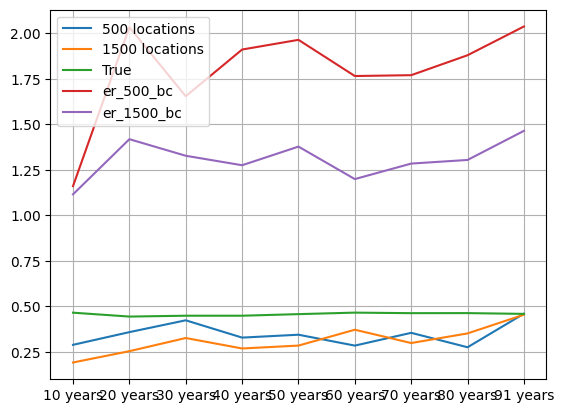

In [16]:
plt.plot(abs_er500,label='500 locations')
plt.plot(abs_er1500,label ='1500 locations')
plt.plot(abs_erfor,label='True')
plt.plot(er500loc_act.abs().mean(axis=0),label='er_500_bc')
plt.plot(er1500loc_act.abs().mean(axis=0),label='er_1500_bc')
plt.legend()
plt.grid()

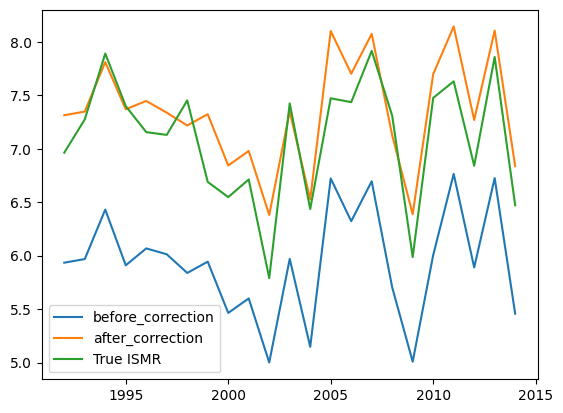

In [17]:
plt.plot(range(1992,2015),df500loc_bc['10 years'],label='before_correction')
plt.plot(range(1992,2015),df500loc_ac['10 years'],label='after_correction')
plt.plot(range(1992,2015),df_true_forecasting['10 years'],label='True ISMR')
plt.legend()

In [18]:
df500loc_bc.to_csv('error_correction_Data_GPR/spa_estimation_500_locations_bc_GPR',float_format='%.8f')
df800loc_bc.to_csv('error_correction_Data_GPR/spa_estimation_800_locations_bc_GPR',float_format='%.8f')
df1000loc_bc.to_csv('error_correction_Data_GPR/spa_estimation_1000_locations_bc_GPR',float_format='%.8f')
df1500loc_bc.to_csv('error_correction_Data_GPR/spa_estimation_1500_locations_bc_GPR',float_format='%.8f')

df500loc_ac.to_csv('error_correction_Data_GPR/spa_estimation_500_locations_ac_GPR',float_format='%.8f')
df800loc_ac.to_csv('error_correction_Data_GPR/spa_estimation_800_locations_ac_GPR',float_format='%.8f')
df1000loc_ac.to_csv('error_correction_Data_GPR/spa_estimation_1000_locations_ac_GPR',float_format='%.8f')
df1500loc_ac.to_csv('error_correction_Data_GPR/spa_estimation_1500_locations_ac_GPR',float_format='%.8f')

df_true_forecasting.to_csv('error_correction_Data_GPR/True_ISMR_entire_set_GPR',float_format='%.8f')
df_predicted_forecasting.to_csv('error_correction_Data_GPR/Prediction_through_entire_set_GPR',float_format='%.8f')

er500loc_act.to_csv('error_correction_Data_GPR/error_actual_500_locations_92to14_GPR',float_format='%.8f')
er800loc_act.to_csv('error_correction_Data_GPR/error_actual_800_locations_92to14_GPR',float_format='%.8f')
er1000loc_act.to_csv('error_correction_Data_GPR/error_actual_1000_locations_92to14_GPR',float_format='%.8f')
er1500loc_act.to_csv('error_correction_Data_GPR/error_actual_1500_locations_92to14_GPR',float_format='%.8f')

er500loc_pred.to_csv('error_correction_Data_GPR/error_predicted_500_locations_92to14_GPR',float_format='%.8f')
er800loc_pred.to_csv('error_correction_Data_GPR/error_predicted_800_locations_92to14_GPR',float_format='%.8f')
er1000loc_pred.to_csv('error_correction_Data_GPR/error_predicted_1000_locations_92to14_GPR',float_format='%.8f')
er1500loc_pred.to_csv('error_correction_Data_GPR/error_predicted_1500_locations_92to14_GPR',float_format='%.8f')